In [2]:
import pandas as pd
import os

# Load label file
label_df = pd.read_excel('../Data/wax/data labels anna - simple.xlsx')
# clean up column names
label_df.columns = ['code', 'month', 'ID', 'optimality', 'abnormal', 'AIMS']
print(label_df.head())

# Cleanup data, remove rows where AIMS score is 999
#cleaned_label_df = label_df[label_df.AIMS != 999]


   code  month   ID  optimality  abnormal  AIMS
0  1023      0  180           9       1.0     1
1  1023      1  195          14       1.0   999
2  1023      2  197          26       1.0     1
3  1023      3  206          11       1.0     2
4  1023      4  208          13       1.0     1


processing instance 0
File not found for instance 0
processing instance 1
RA rows: 103571
LA rows: 105343
RW rows: 109137
LW rows: 107024
Minimum number of rows: 103571
First column is the same for each df
Start peak index: 19091
End peak index: 103566
processing instance 2
File not found for instance 2
processing instance 3
File not found for instance 3
processing instance 4
File not found for instance 4
processing instance 5
File not found for instance 5
processing instance 6
File not found for instance 6
processing instance 7
RA rows: 175875
LA rows: 178059
RW rows: 185364
LW rows: 181948
Minimum number of rows: 175875
First column is the same for each df
Start peak index: 41829
End peak index: 175783
processing instance 8
RA rows: 219319
LA rows: 225325
RW rows: 234538
LW rows: 220757
Minimum number of rows: 219319
First column is the same for each df
Start peak index: 22382
End peak index: 219110
processing instance 9
RA rows: 219197
LA rows: 226647
RW rows: 235099
LW rows: 233568

c:\Users\User\OneDrive - University of Glasgow\Documents\5th Year\Abnormal Infant Movement Detection\Abnormal-Infant-Movement-Detection\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Start peak index: 13329
End peak index: 113051
processing instance 11
File not found for instance 11
           Time   AccXRA   AccYRA   AccZRA  GyrXRA  GyrYRA  GyrZRA  MagXRA  \
0          0.01  0.01172 -0.00098  1.00000    0.00    2.03   -2.66   -13.3   
1          0.02  0.01172 -0.00391  1.00000    0.00    2.03   -5.53   -13.3   
2          0.03  0.01074 -0.00488  1.00000    0.14    2.03   -5.53   -11.5   
3          0.04  0.00781 -0.00488  1.00000    0.21    1.96   -5.81   -11.5   
4          0.05  0.00391 -0.00488  0.99902    0.14    1.96   -5.81   -12.2   
...         ...      ...      ...      ...     ...     ...     ...     ...   
103566  1035.67  0.01367 -0.91309 -0.40918   -1.05   -0.07   -0.56   -68.4   
103567  1035.68  0.01367 -0.91309 -0.40918   -0.84   -0.28   -0.56   -68.4   
103568  1035.69  0.01465 -0.91504 -0.40918   -0.84   -0.28   -0.56   -68.1   
103569  1035.70  0.01465 -0.91504 -0.41211   -0.98   -0.28   -0.56   -68.1   
103570  1035.71  0.01465 -0.91211 -0.4121

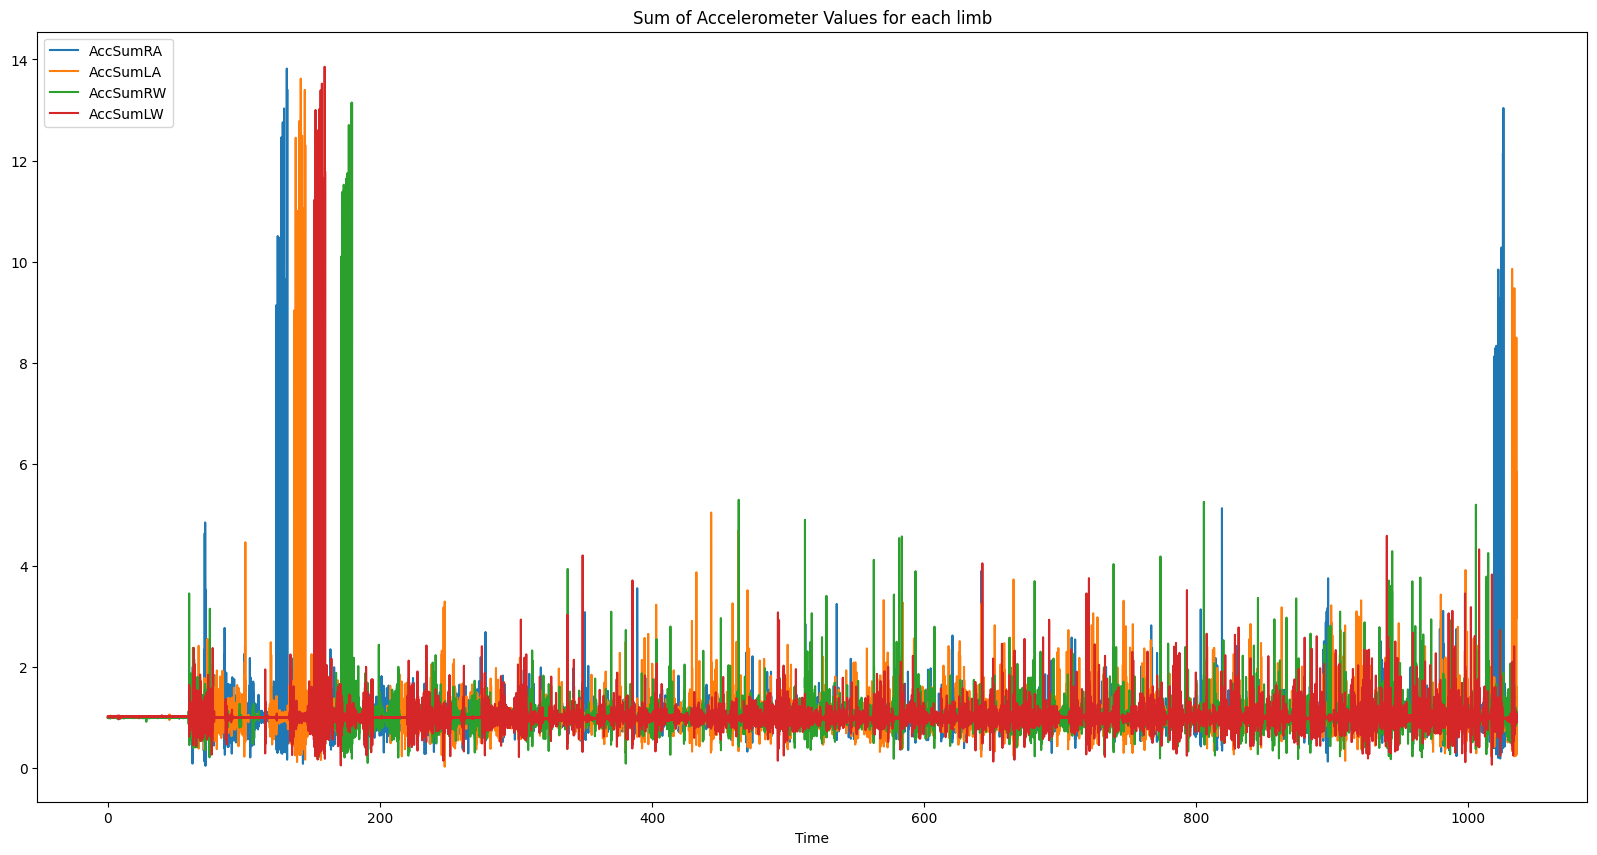

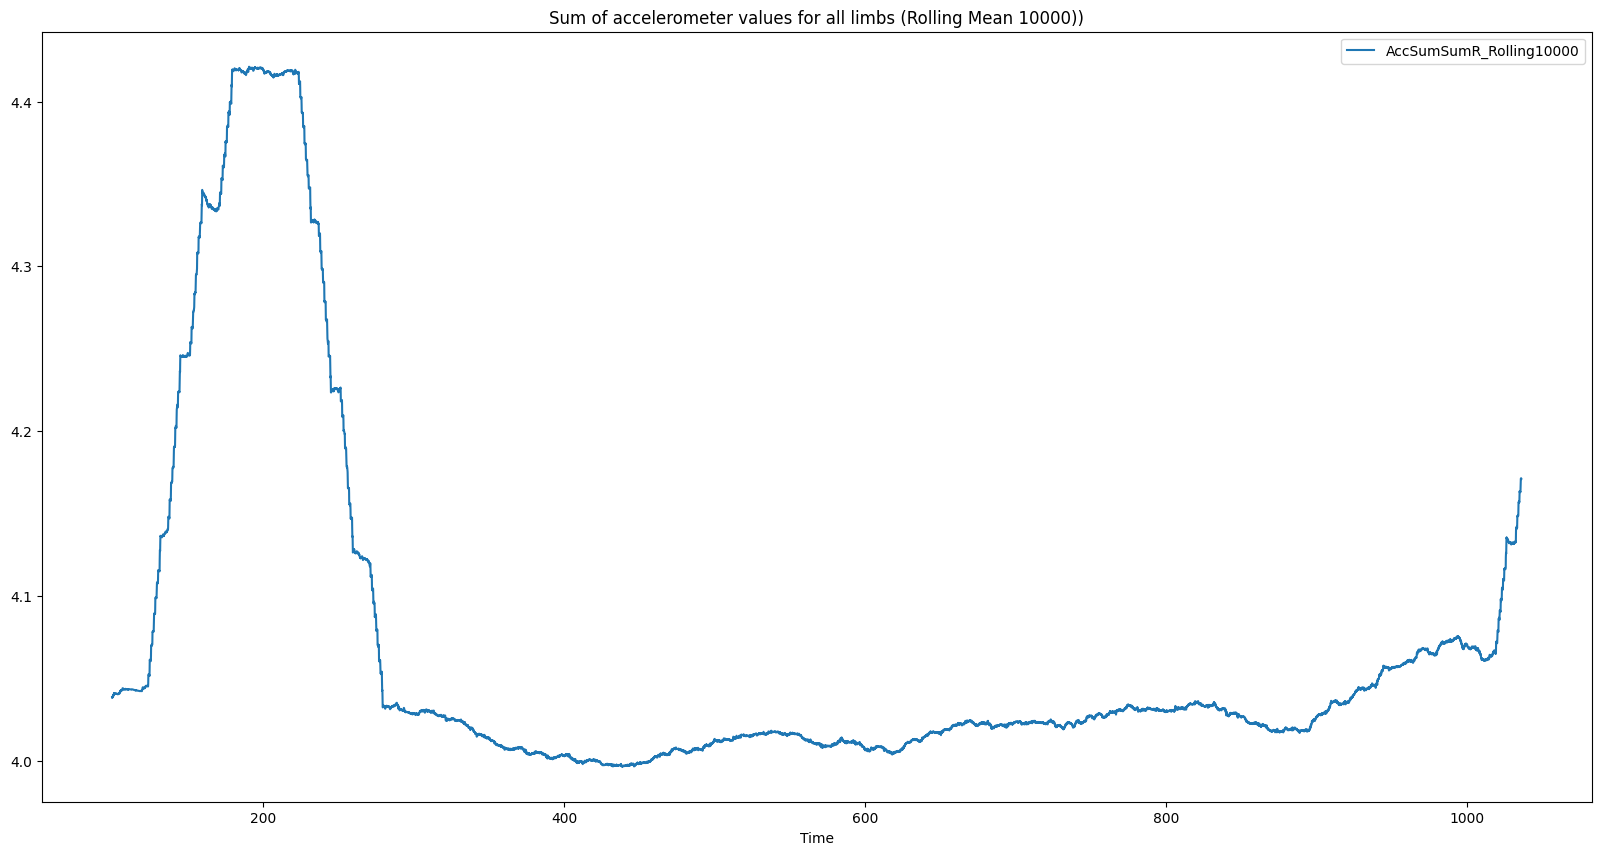

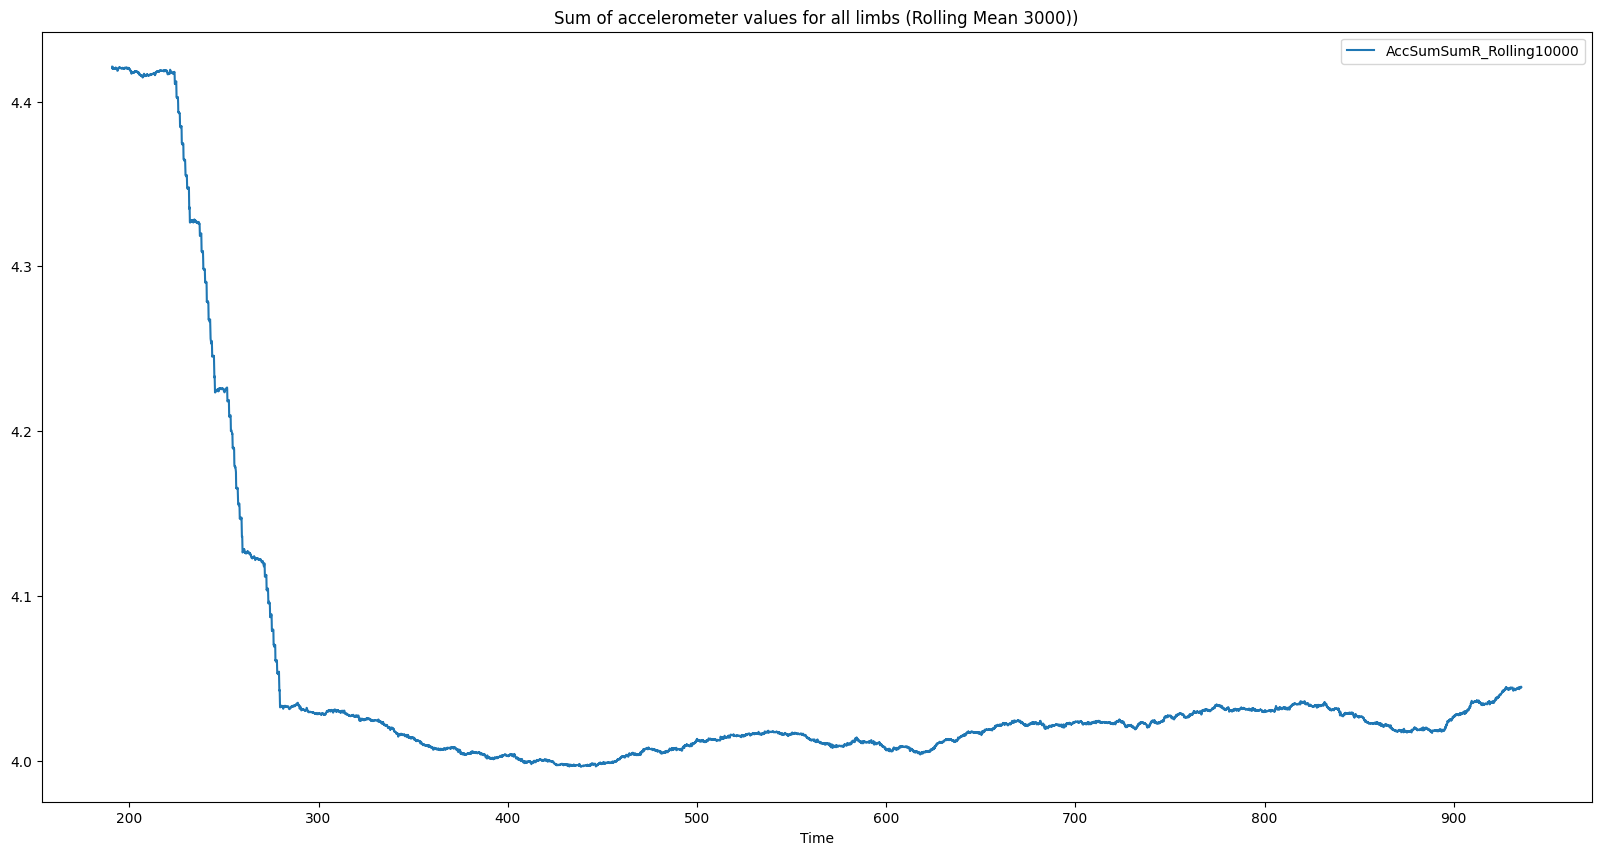

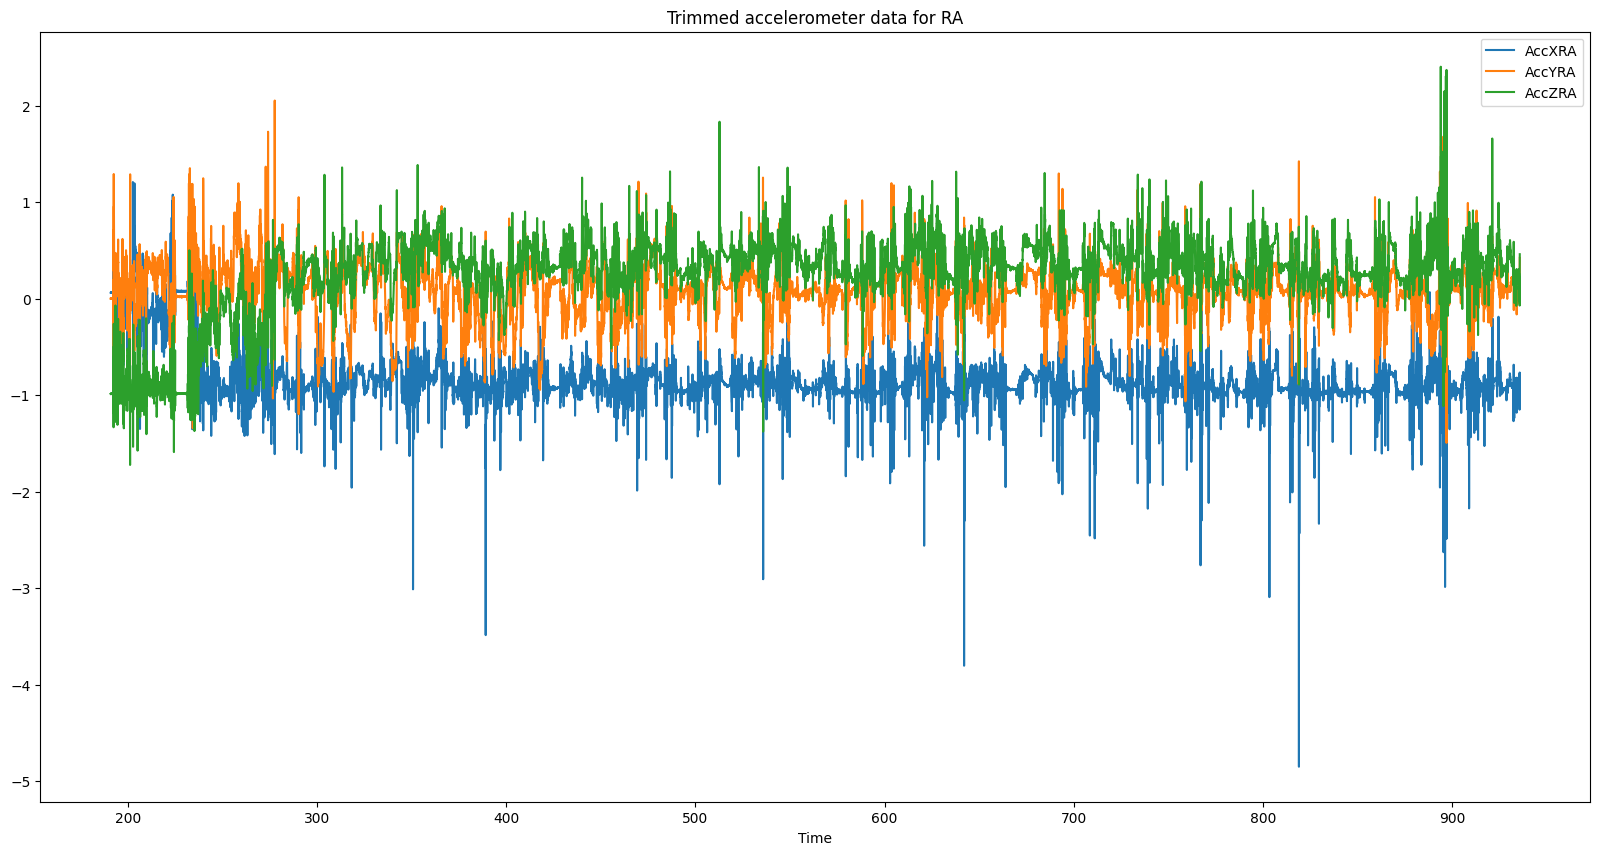

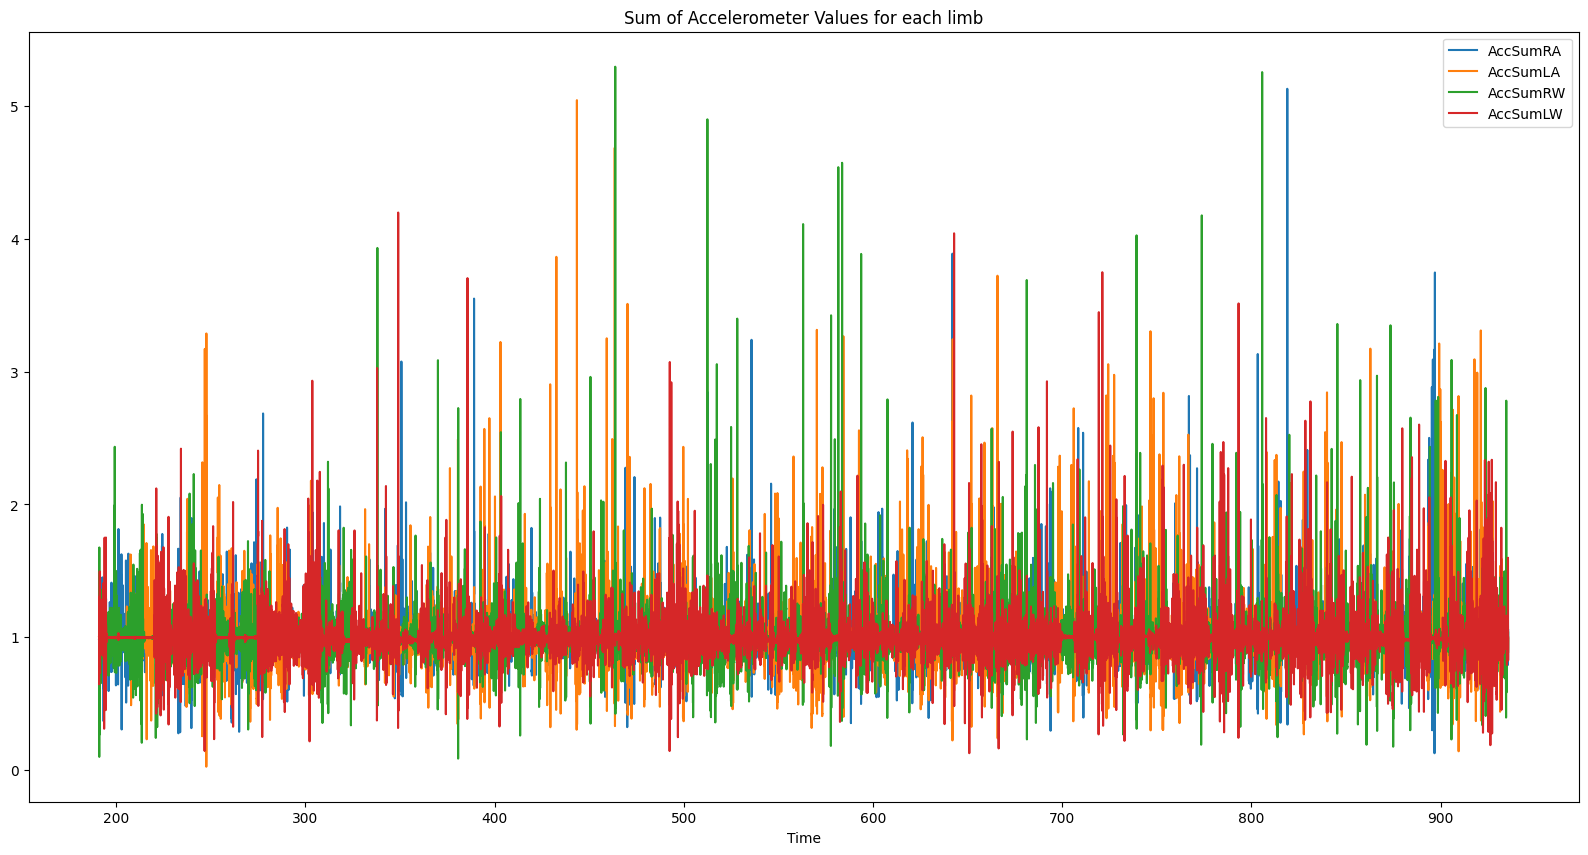

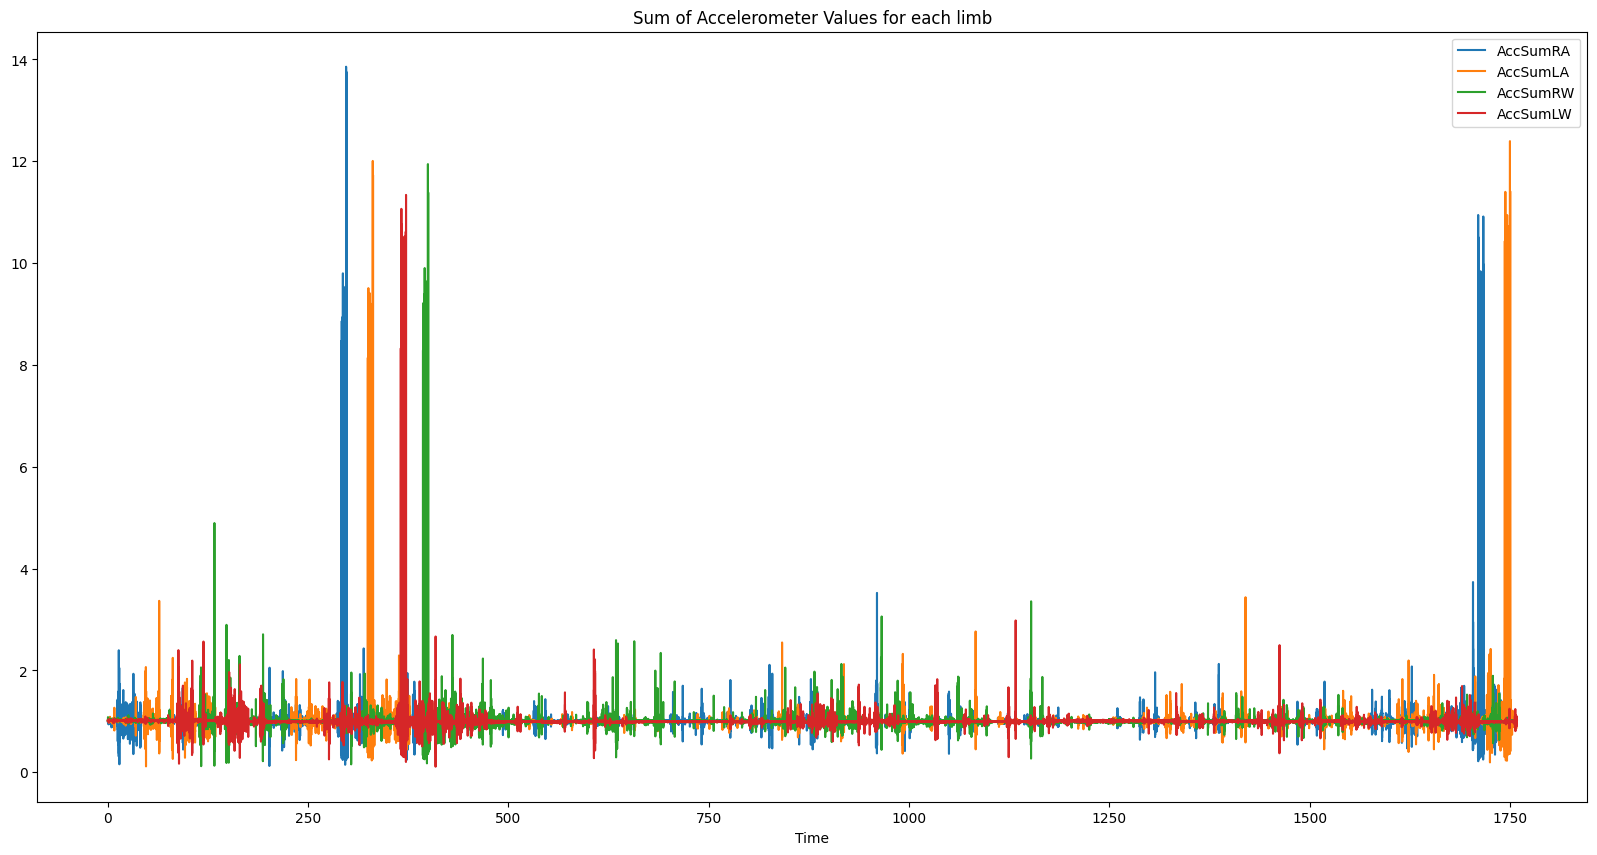

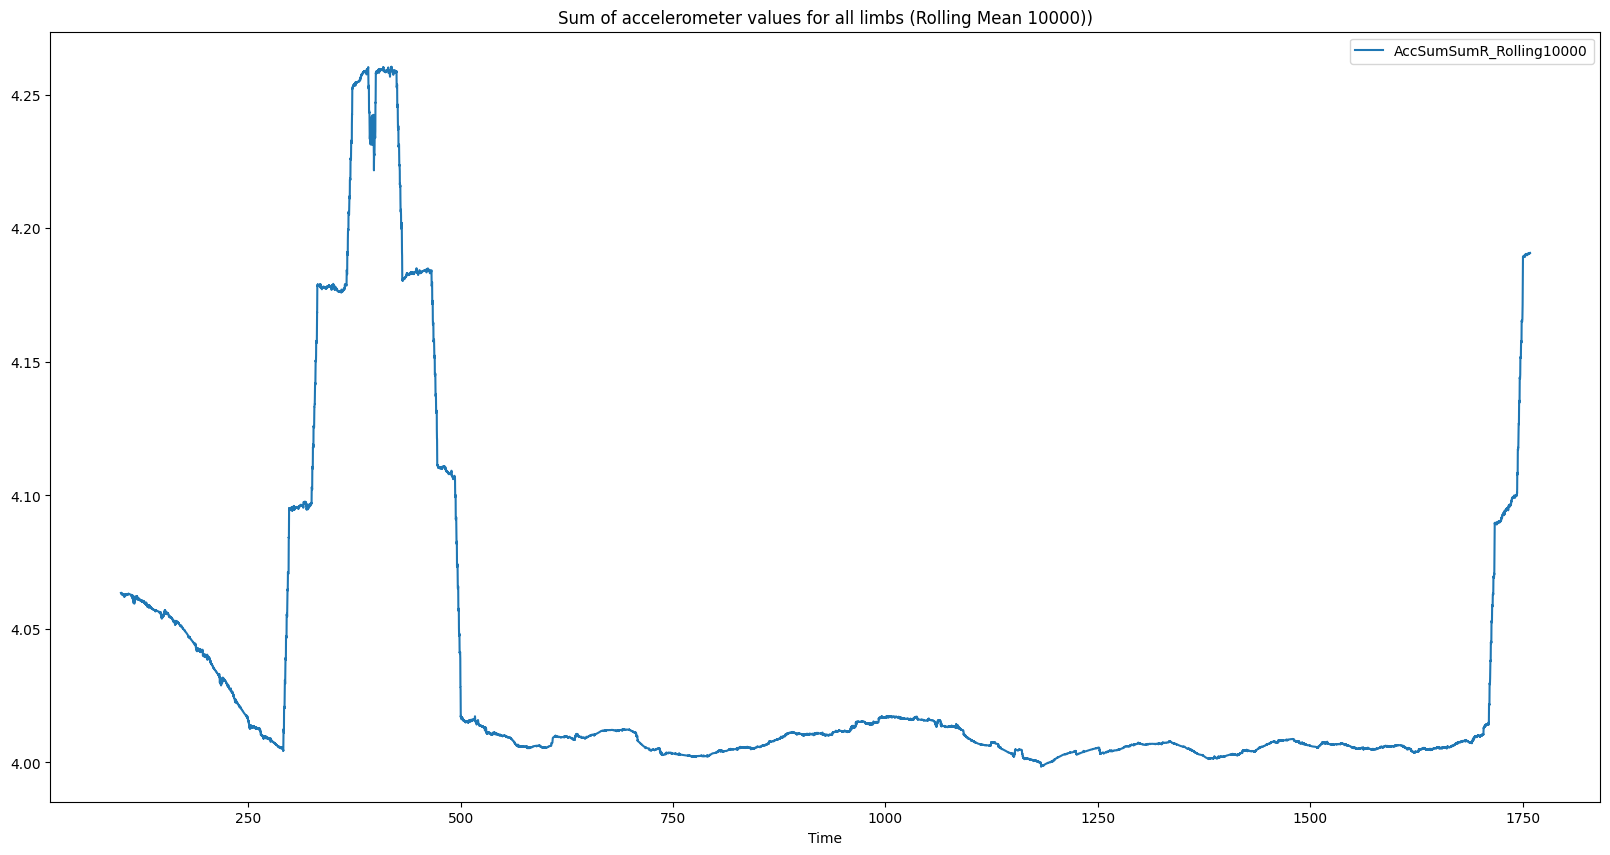

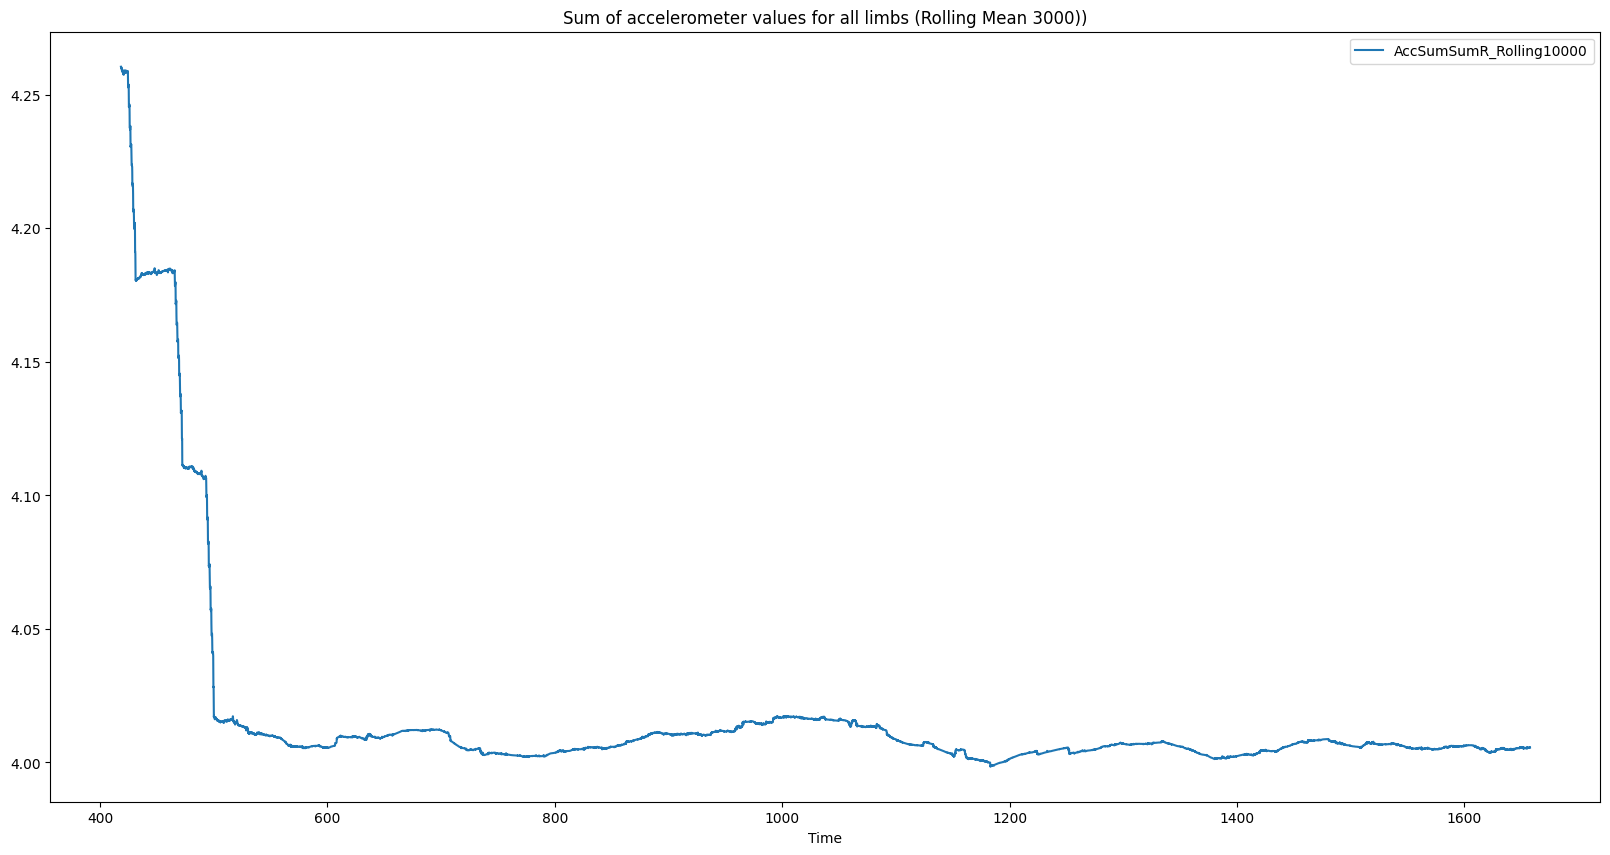

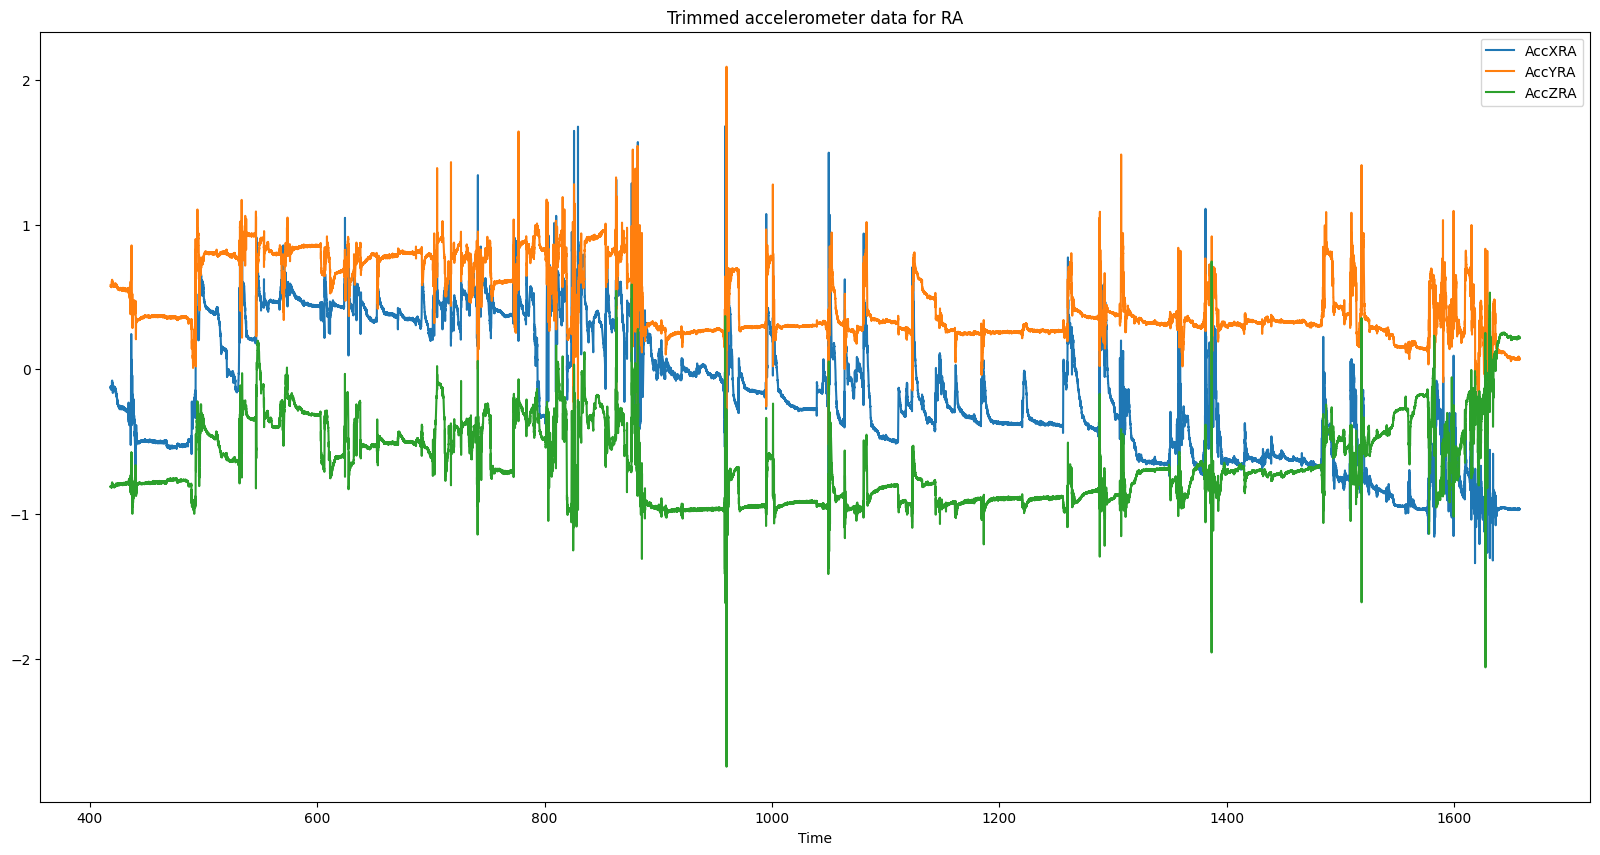

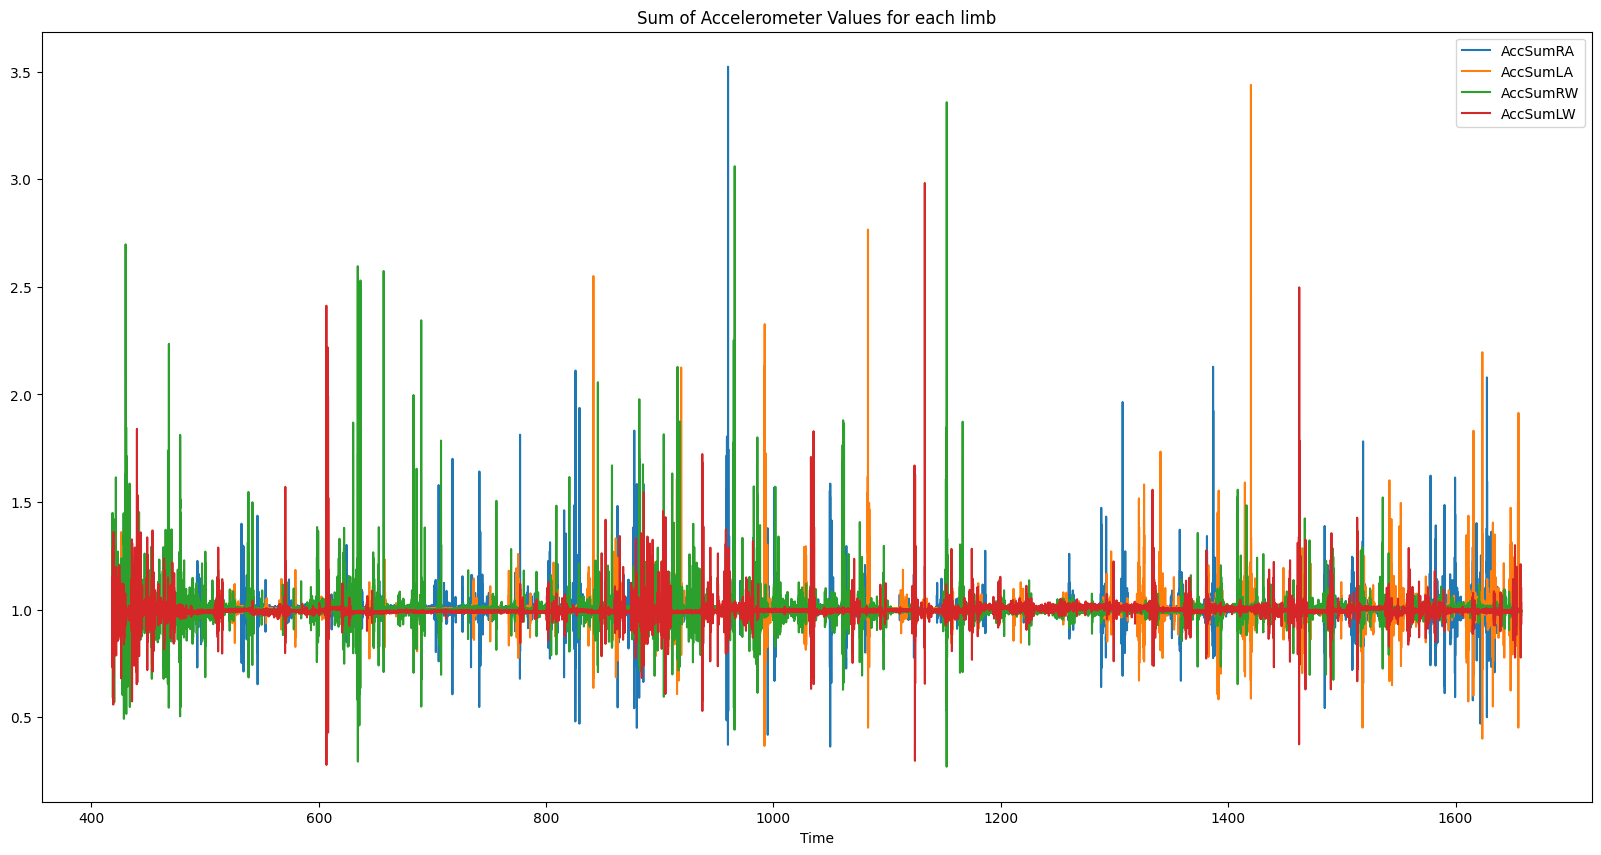

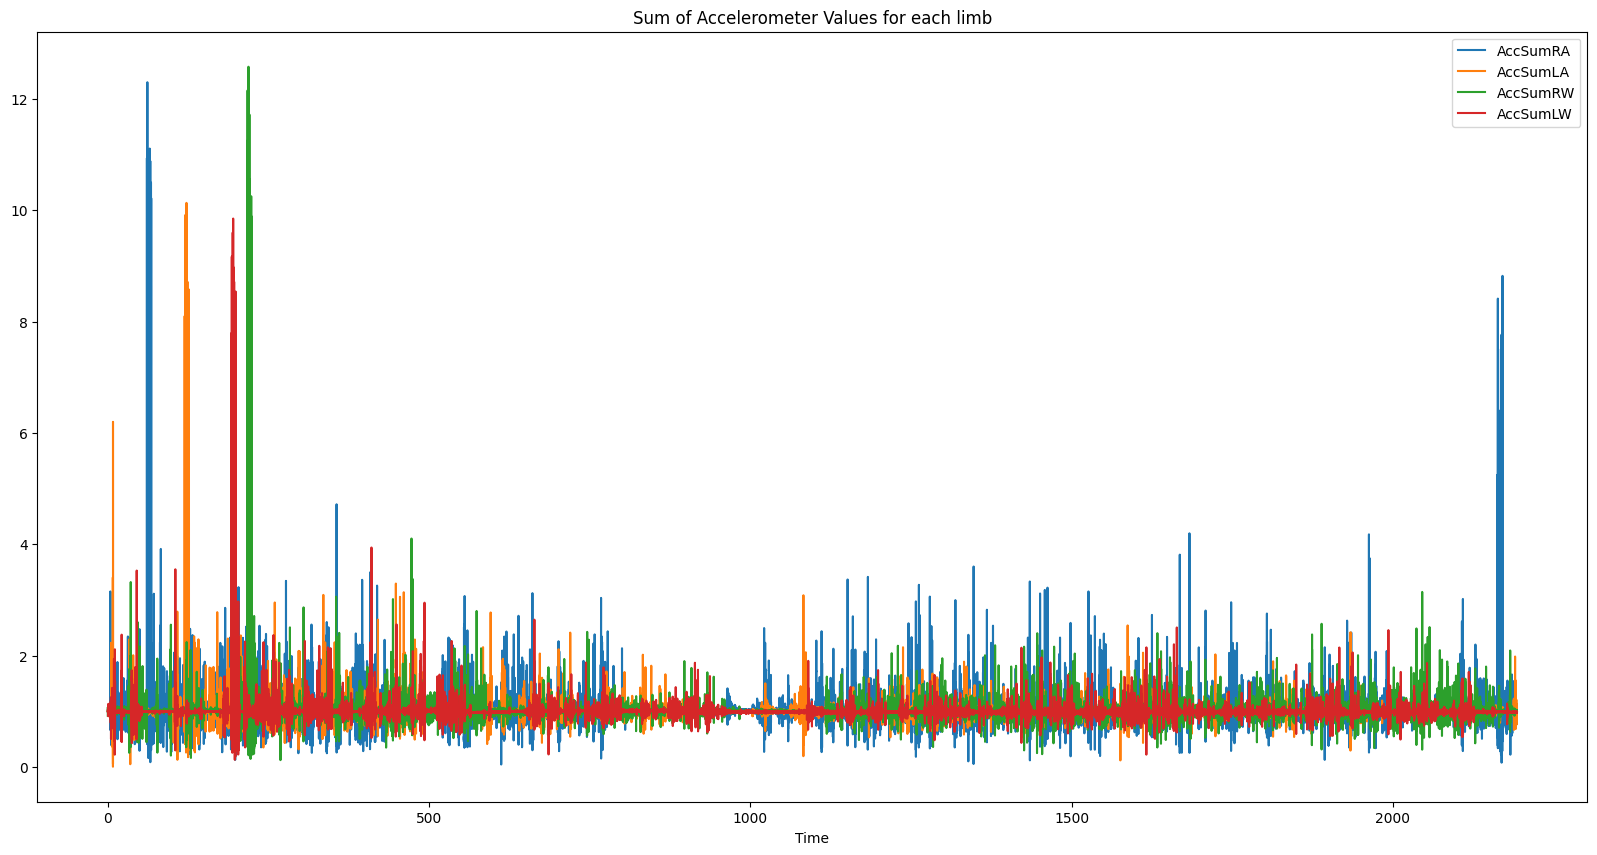

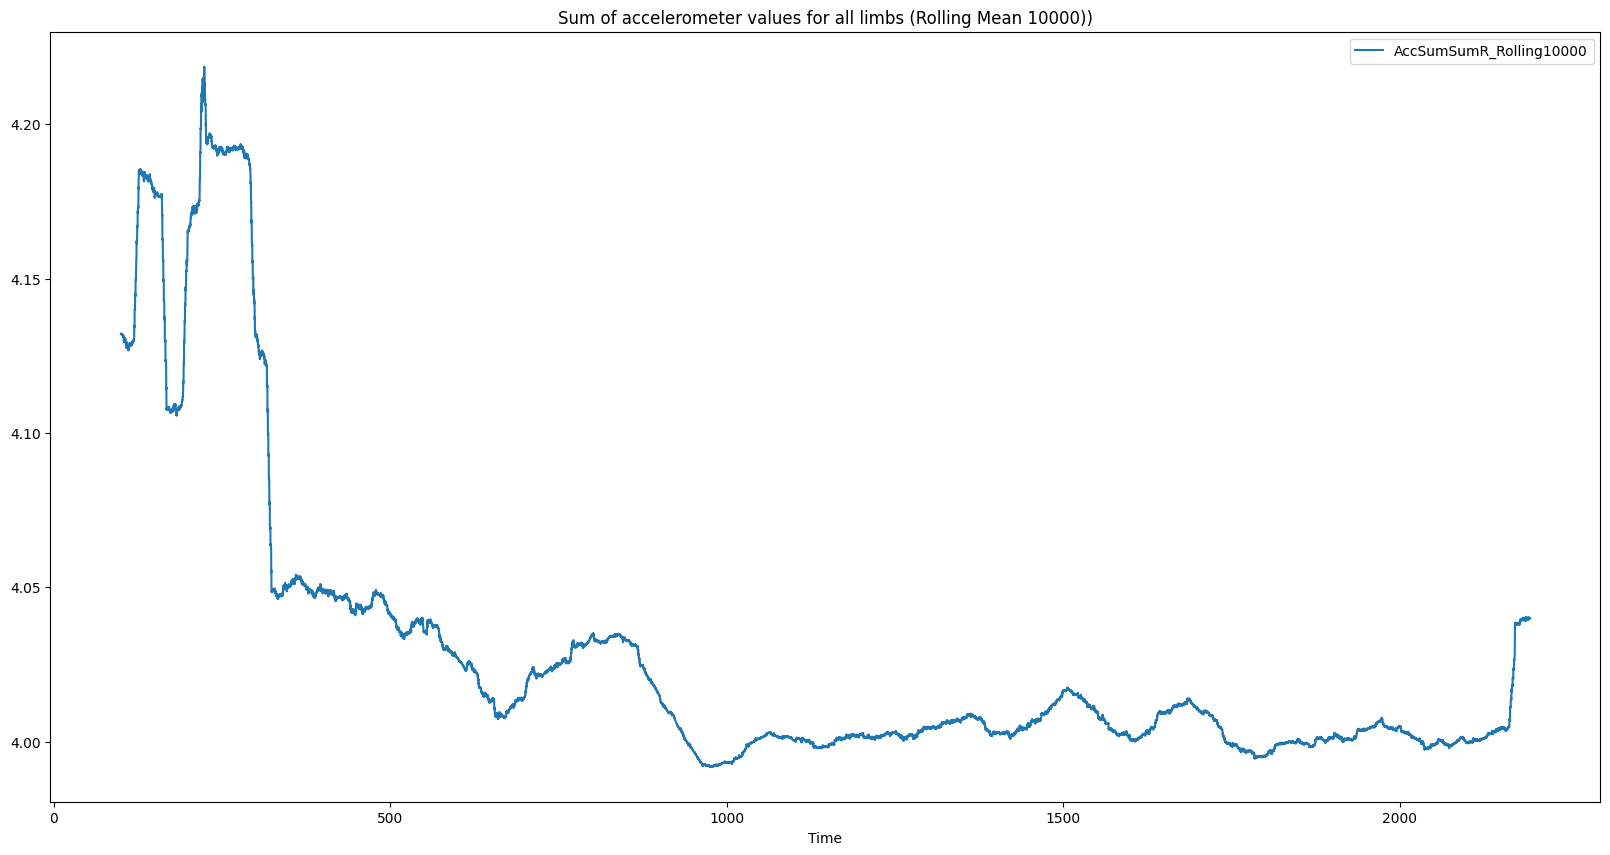

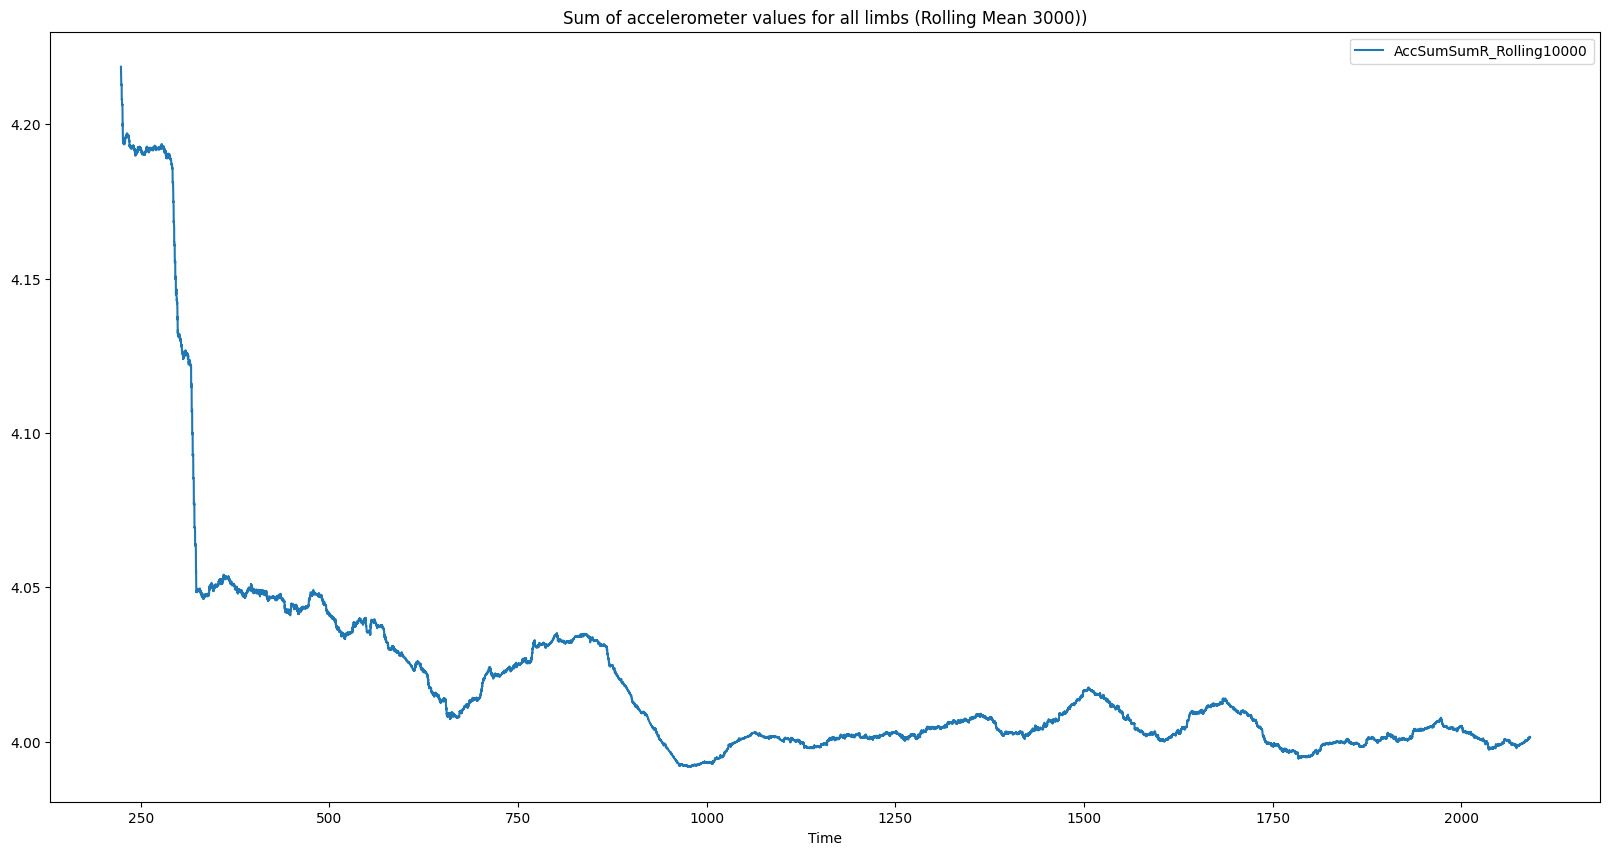

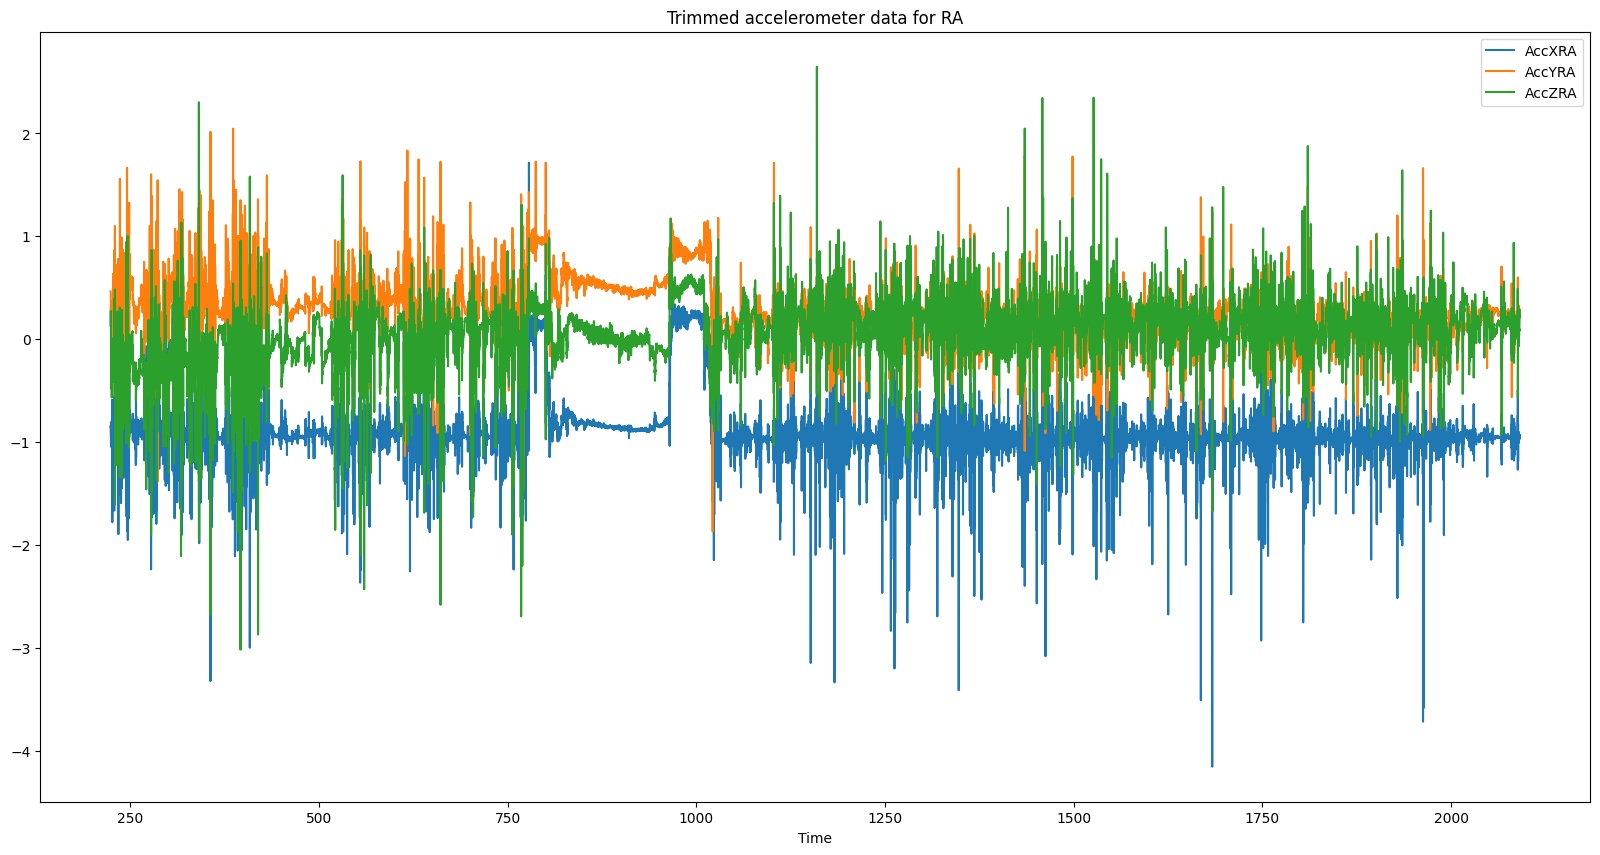

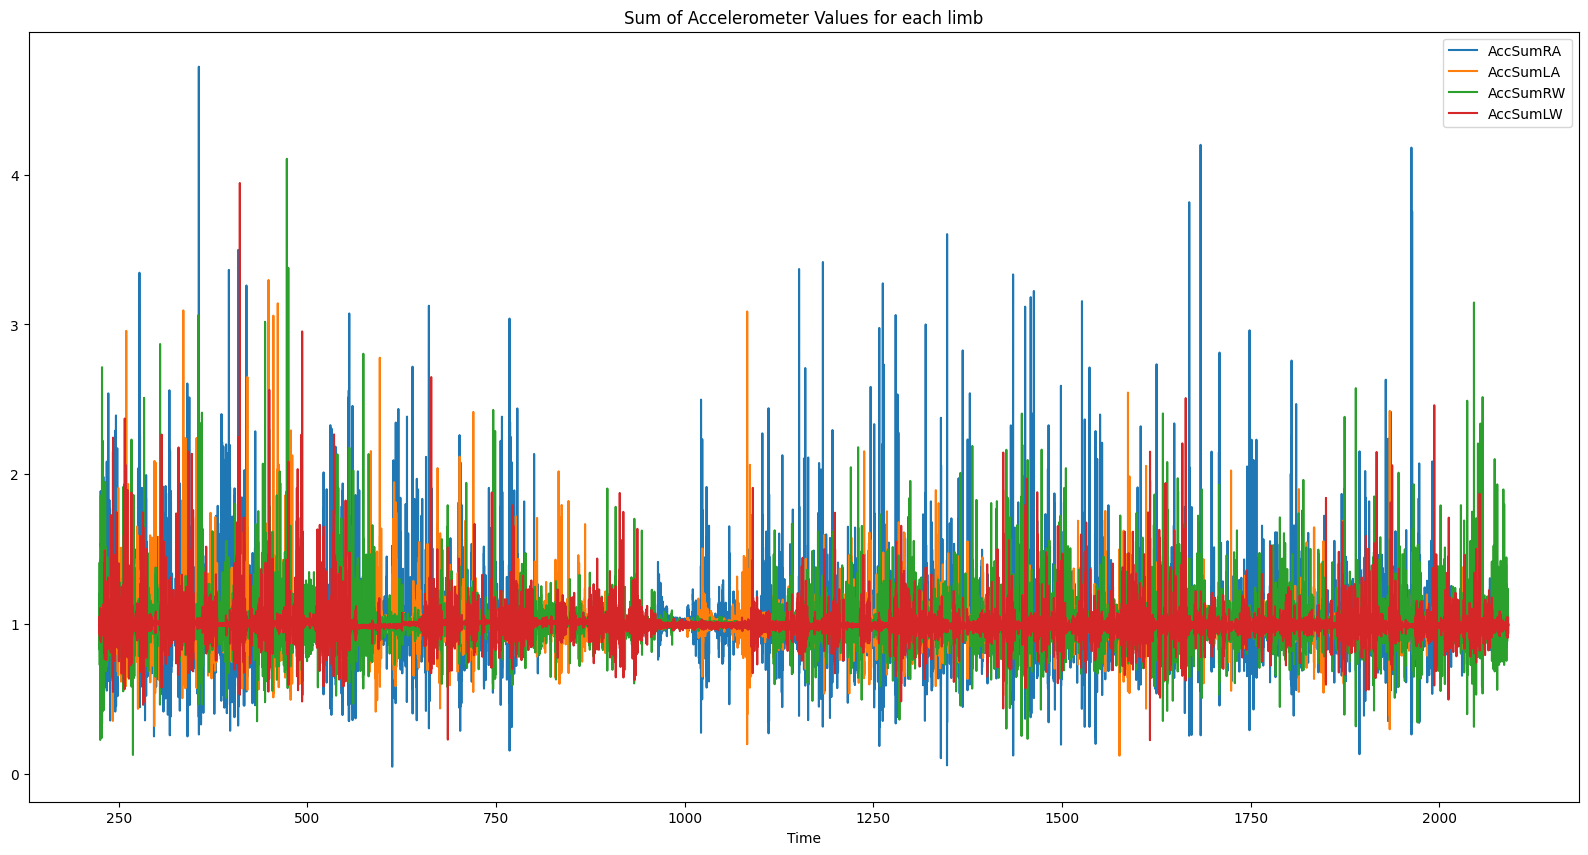

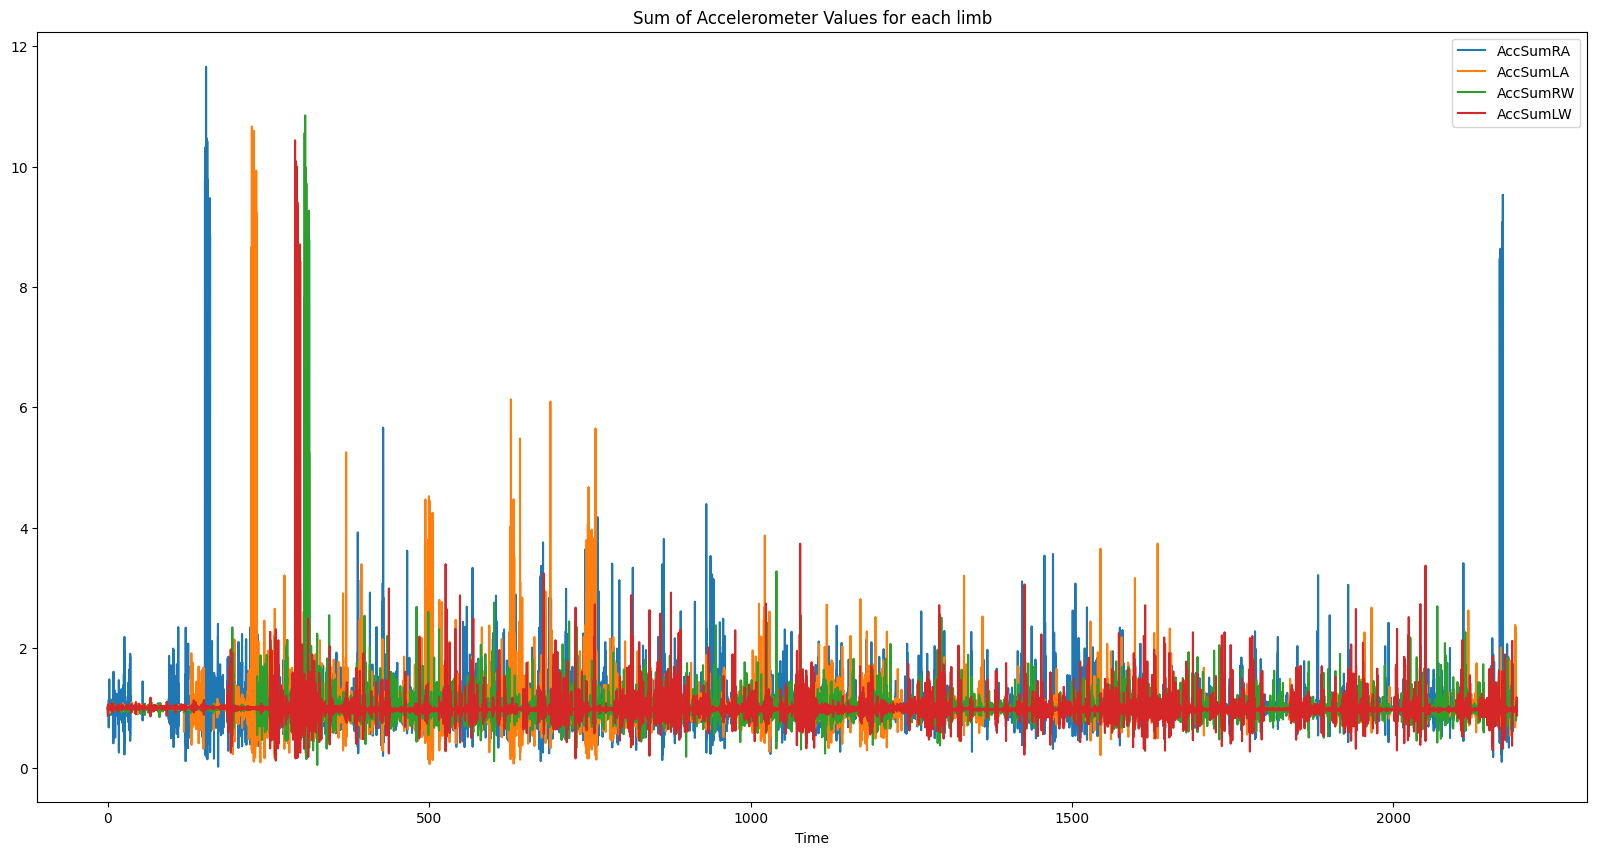

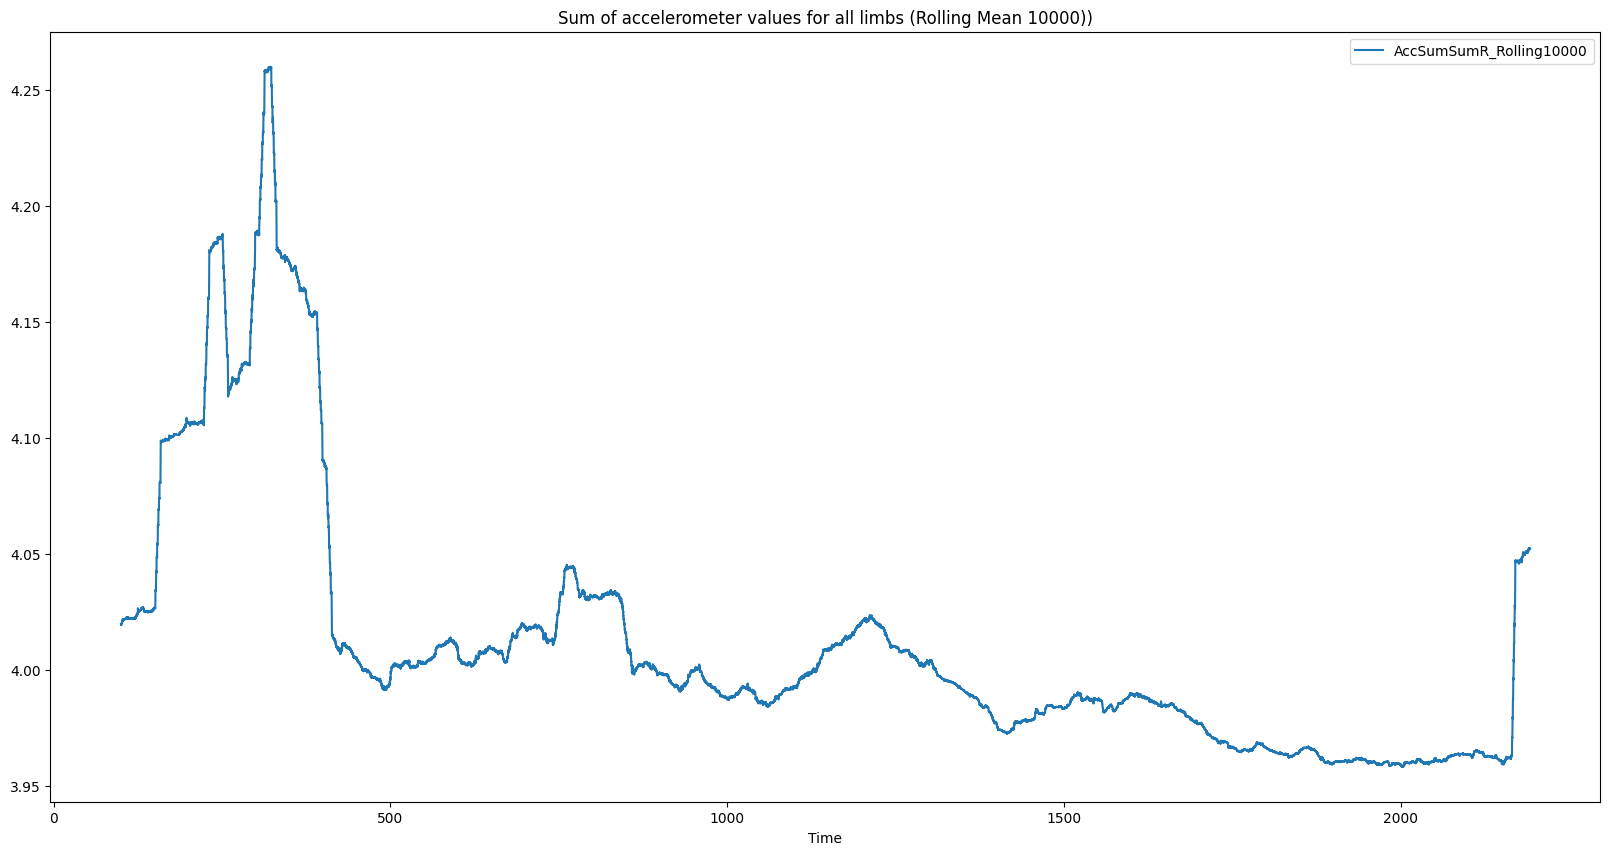

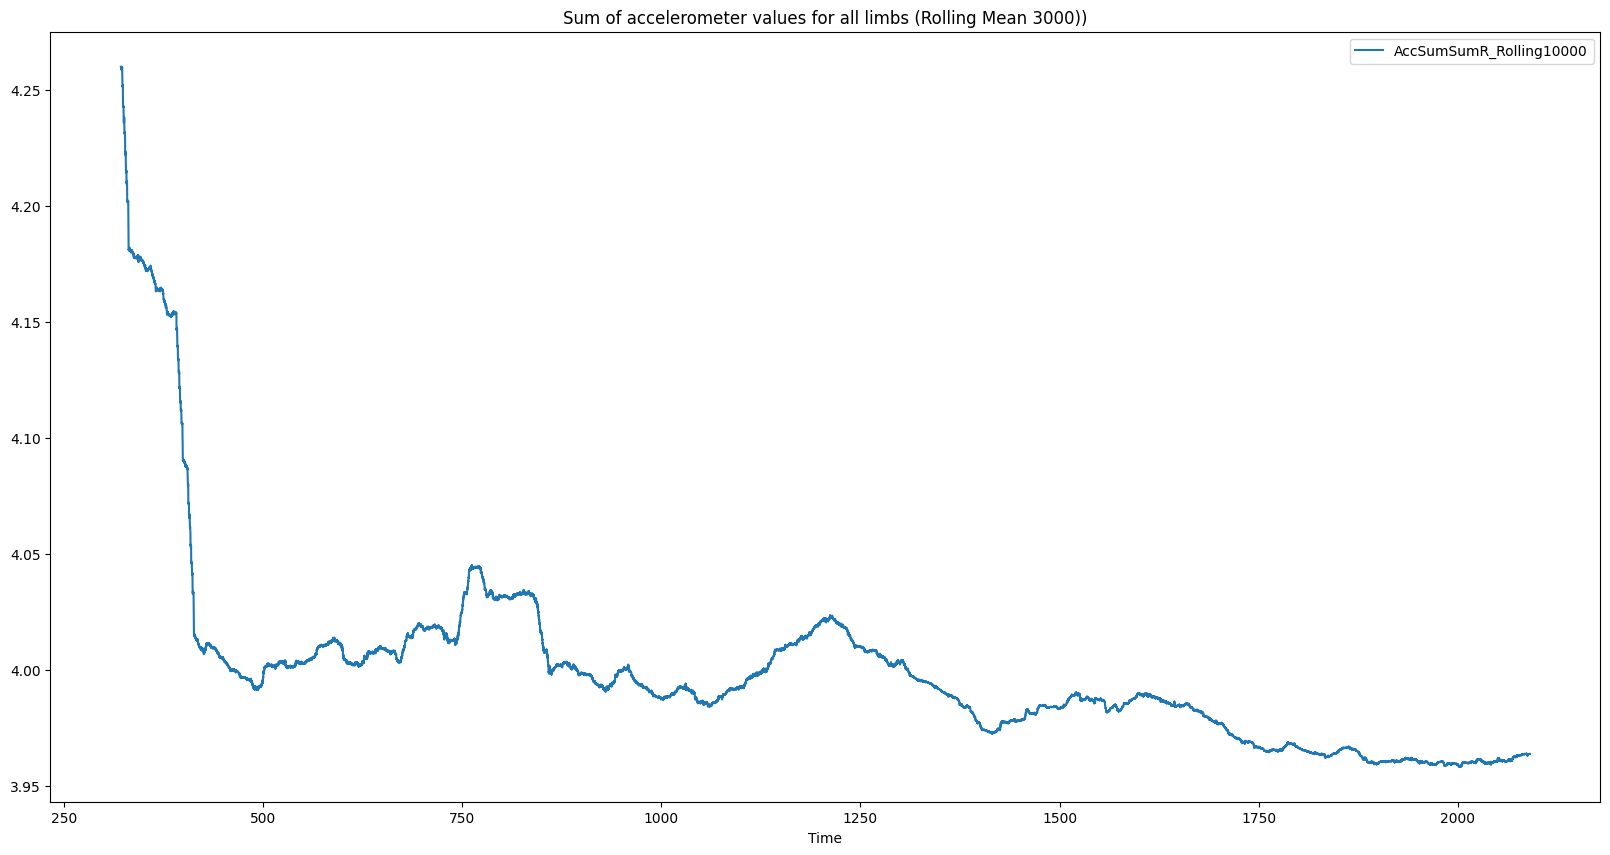

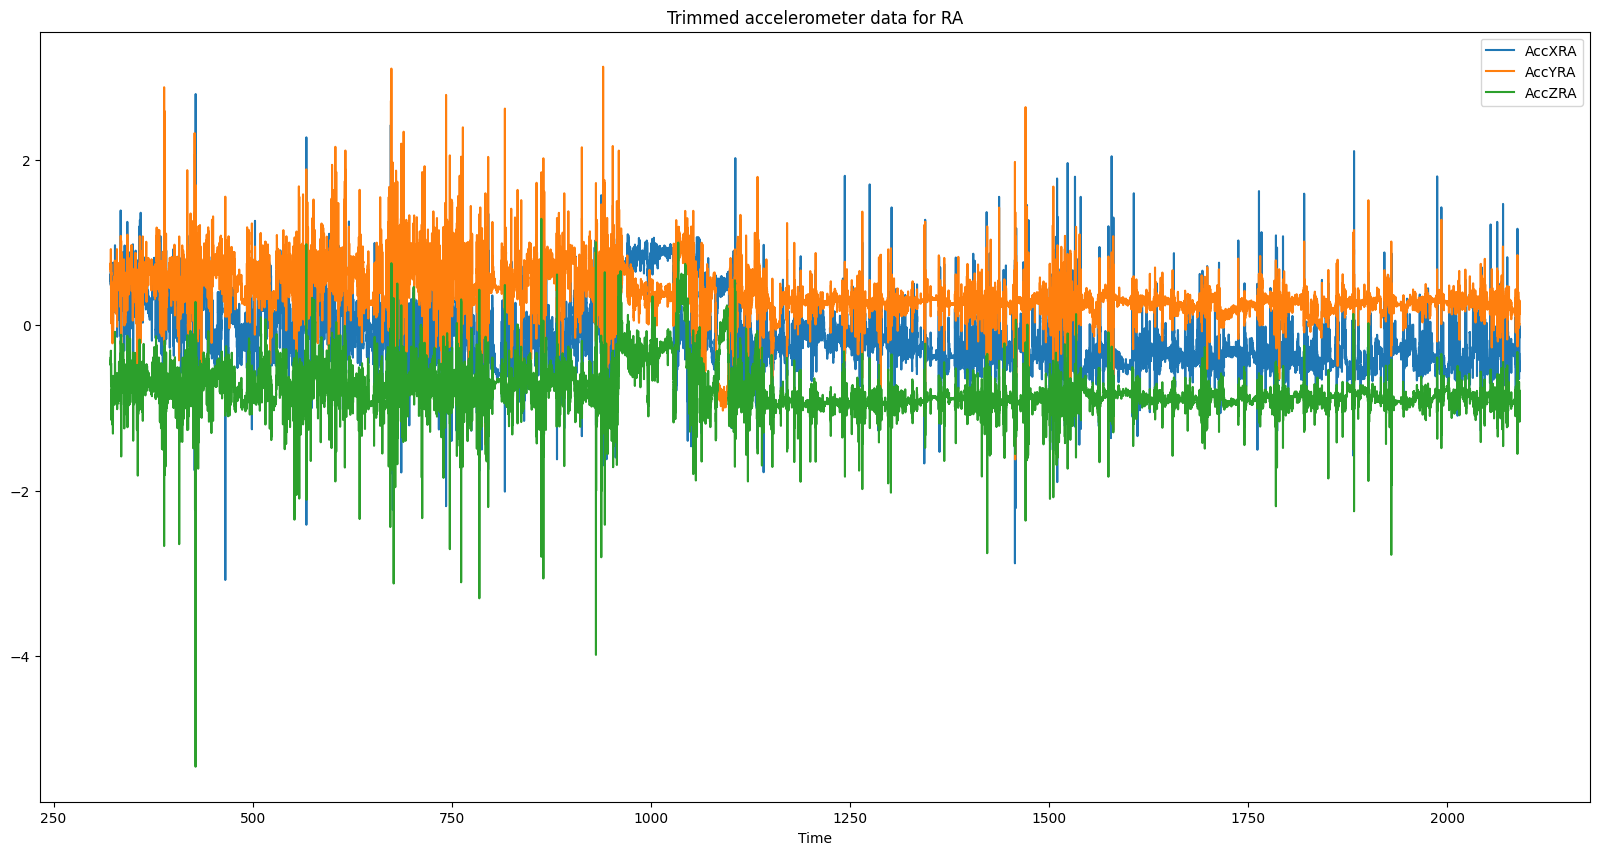

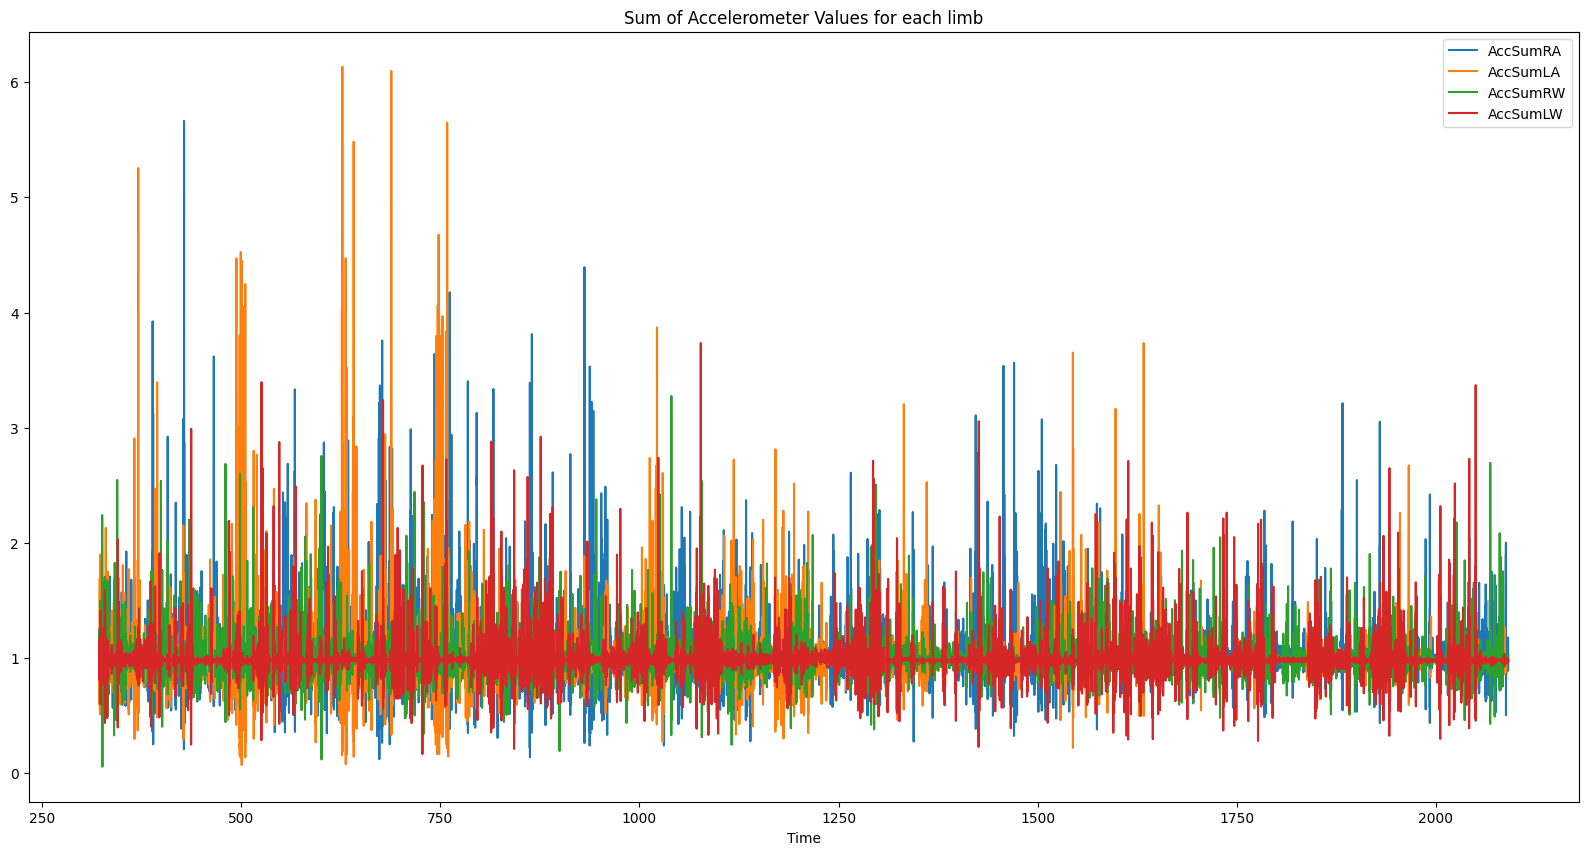

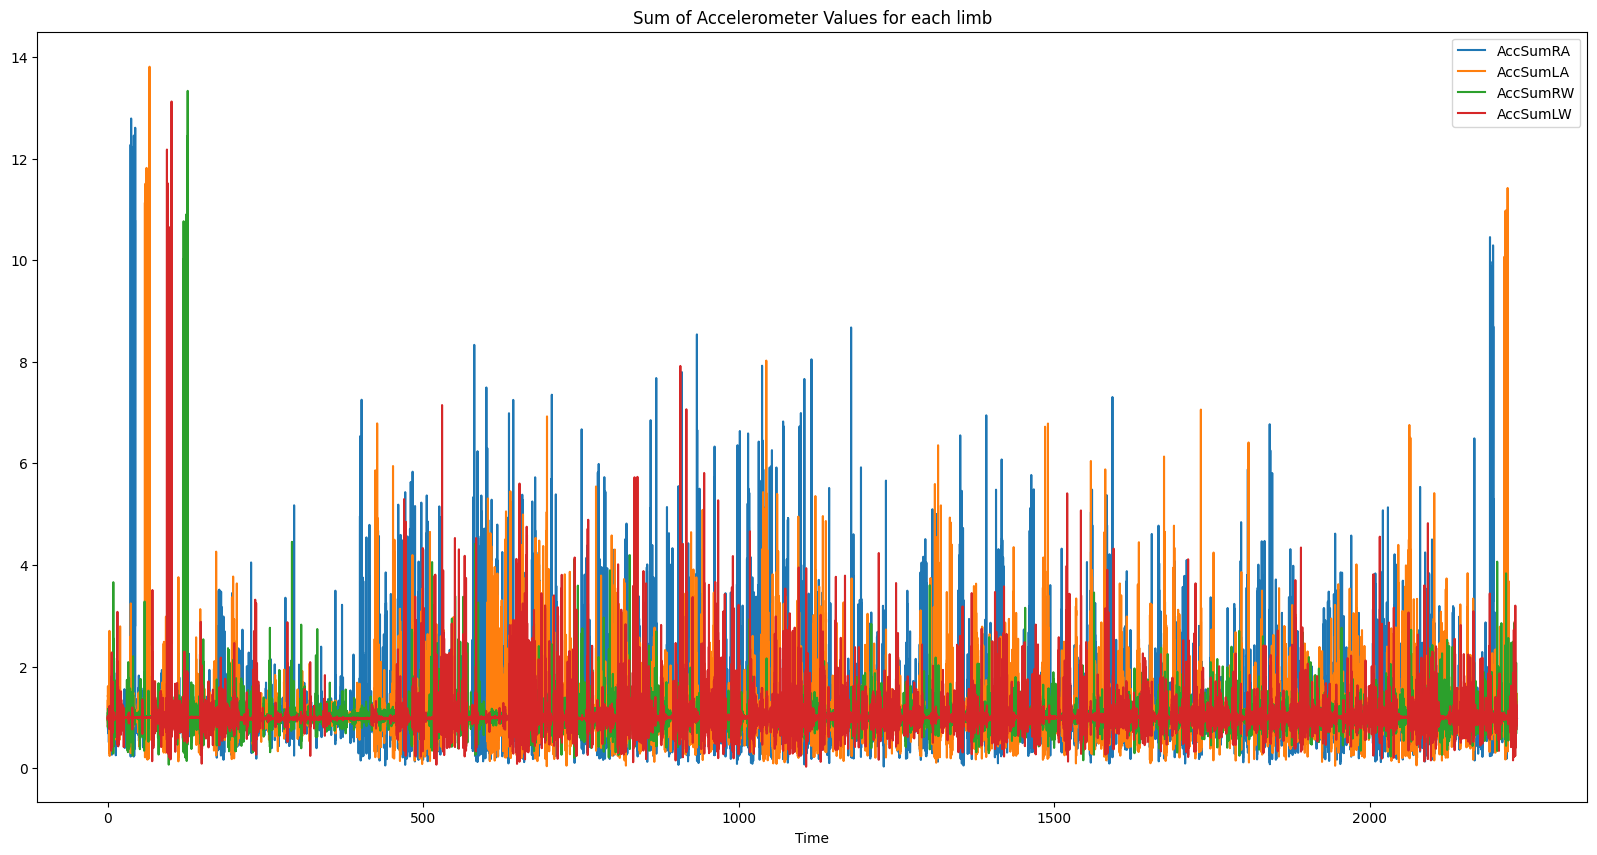

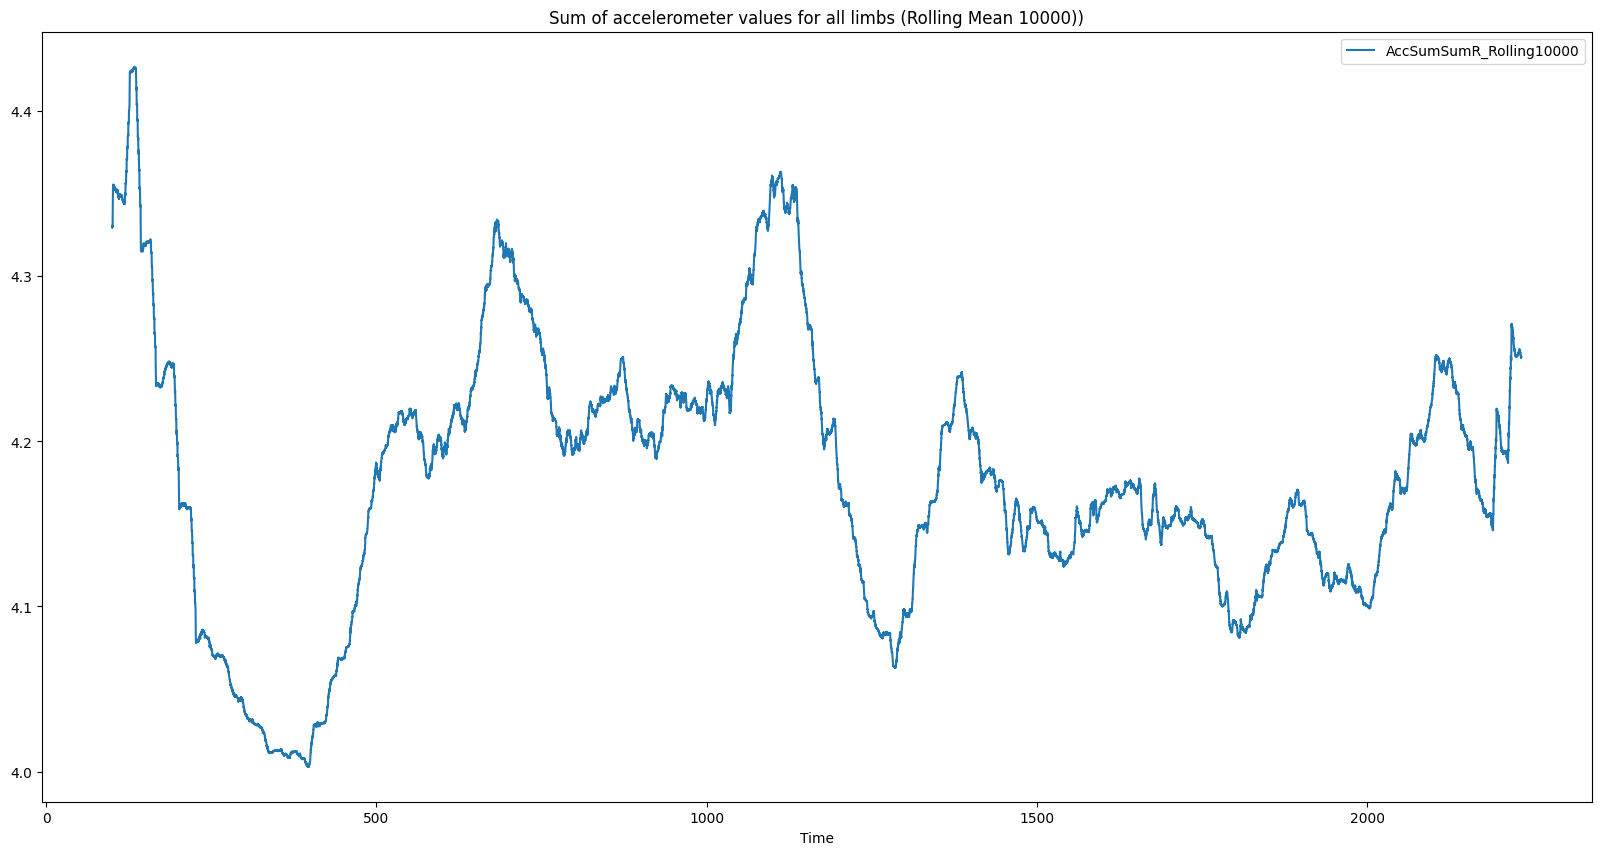

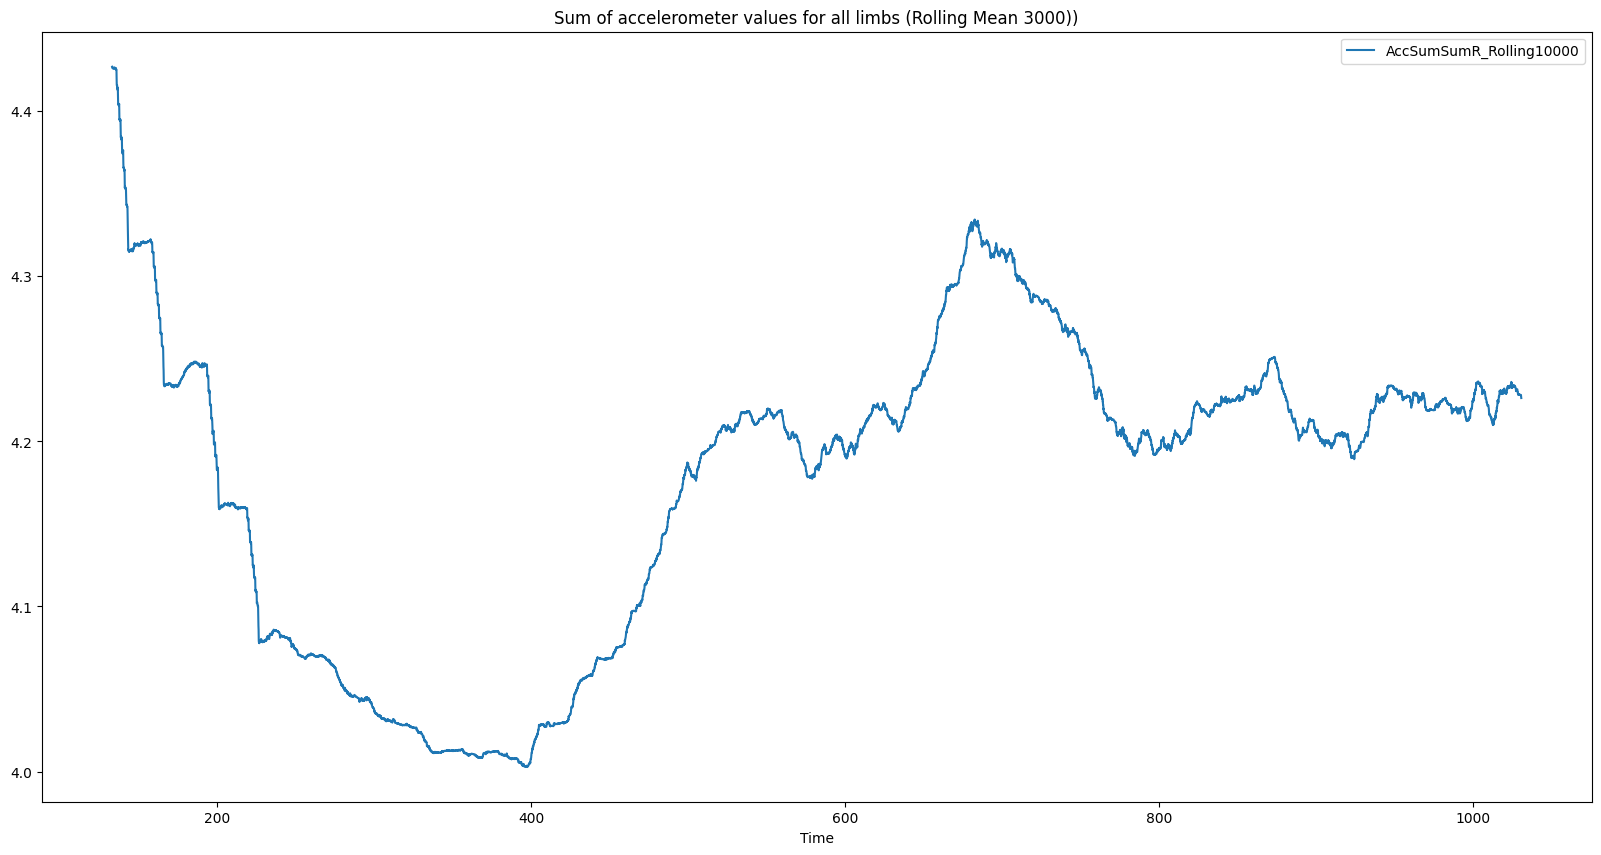

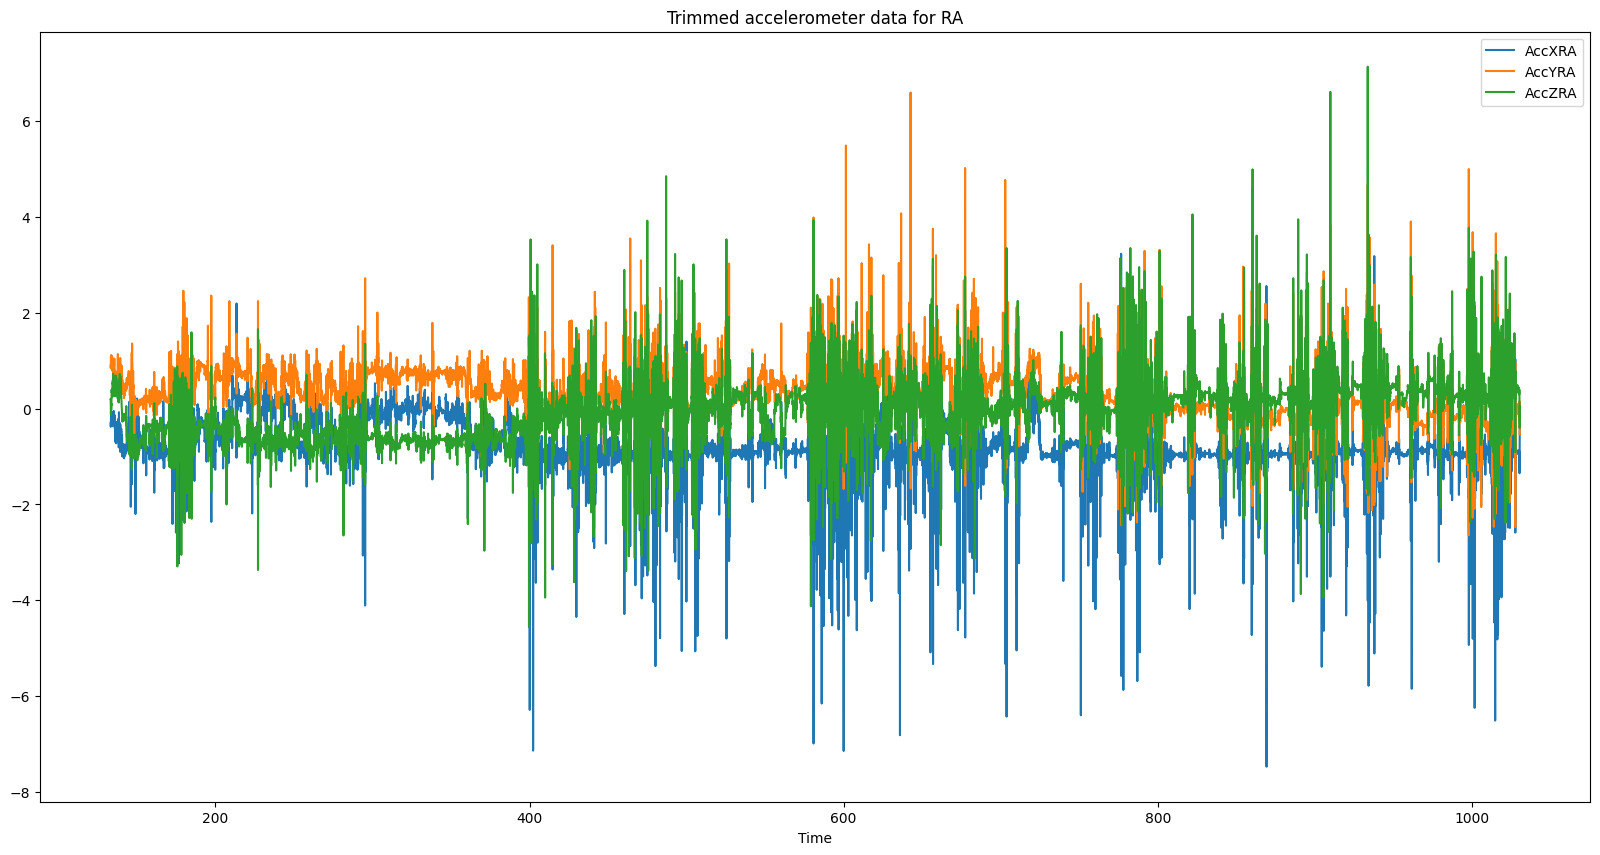

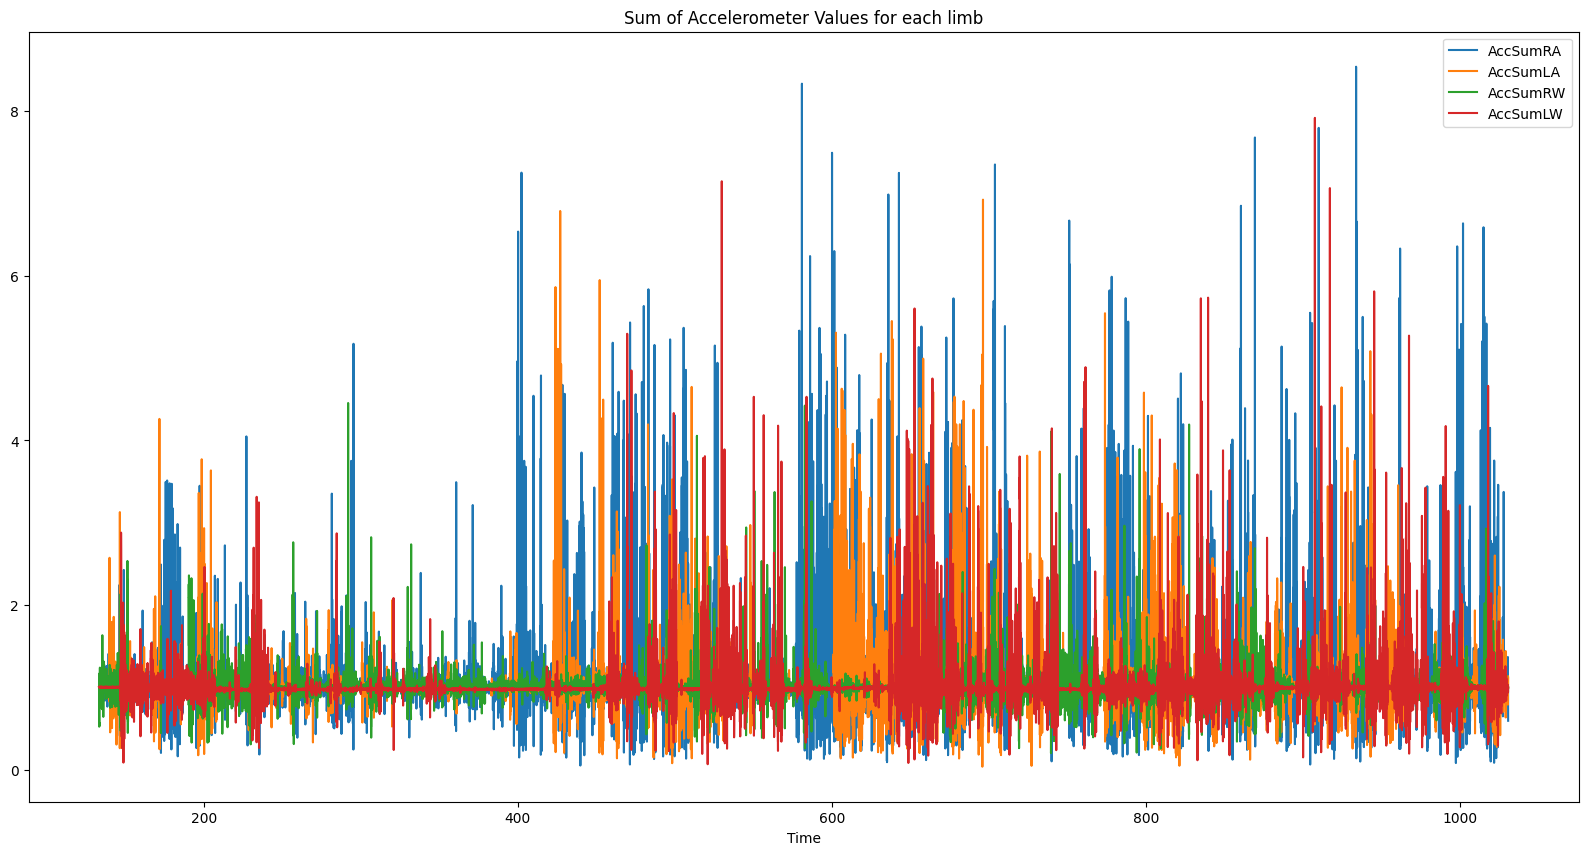

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# For each ID in the label file, find the corresponding file in the data folder
# Iterate through trials

# Initialise empty data structure to hold all sensor data for each trial
# Each trial is in the form of a dataframe

# Data for each trial includes:
    # Infant
    # Sensor data collected from each limb
    # Infant age

# Labels for each trial include:
    # Abnormal / Normal
    # AIMS score
    # Optimality score

sensorX = [] # List of dataframes (just the sensor data)
combinedX = [] # Sensor data, infant ID, infant age
abnormalY = [] # Abnormal / Normal
aimsY = [] # AIMS score
optimalityY = [] # Optimality score



for index, row in label_df.iterrows():
    try:
        print("processing instance", index)
        trial_id = row["ID"]
        infant_id = row["code"]
        if trial_id < 10:
            addedZero = '00'
        elif row['ID'] < 100:
            addedZero = '0'
        else:
            addedZero = ''

        # Access sensor data files
        trial_folder = '../Data/wax/p' + addedZero + str(trial_id)

        # Access sensor data files
        ra_df = pd.read_csv(trial_folder + "/RA.csv")
        la_df = pd.read_csv(trial_folder + "/LA.csv")
        rw_df = pd.read_csv(trial_folder + "/RW.csv")
        lw_df = pd.read_csv(trial_folder + "/LW.csv")
        
        # Drop rows where all entries are zero
        ra_df = ra_df[(ra_df.T != 0).any()]
        la_df = la_df[(la_df.T != 0).any()]
        rw_df = rw_df[(rw_df.T != 0).any()]
        lw_df = lw_df[(lw_df.T != 0).any()]


        # The RA, LA, RW, LW files need to be combined to form a training instance
        # The label file has clinical annotations for each instance

        # Check if the RA, LA, RW, LW files have the same number of rows
        # If not, we need to truncate the longer files
        ra_rows = ra_df.shape[0]
        la_rows = la_df.shape[0]
        rw_rows = rw_df.shape[0]
        lw_rows = lw_df.shape[0]
        print("RA rows:", ra_rows)
        print("LA rows:", la_rows)
        print("RW rows:", rw_rows)
        print("LW rows:", lw_rows)

        # Find the minimum number of rows
        min_rows = min(ra_rows, la_rows, rw_rows, lw_rows)
        print("Minimum number of rows:", min_rows)

        # Truncate the longer files
        ra_df = ra_df[:min_rows]
        la_df = la_df[:min_rows]
        rw_df = rw_df[:min_rows]
        lw_df = lw_df[:min_rows]

        # Check if first column is the same for each df
        ra_col1 = ra_df.columns[0]
        la_col1 = la_df.columns[0]
        rw_col1 = rw_df.columns[0]
        lw_col1 = lw_df.columns[0]
        if ra_col1 == la_col1 == rw_col1 == lw_col1:
            print("First column is the same for each df")
        
        # Remove first column of la, rw, lw dfs
        la_df = la_df.drop(columns=[la_col1])
        rw_df = rw_df.drop(columns=[rw_col1])
        lw_df = lw_df.drop(columns=[lw_col1])

        # Combine the files
        combined_df = pd.concat([ra_df, la_df, rw_df, lw_df], axis=1)
        
        # In each CSV the columns are not labelled correctly. For each CSV we want the columns to be
            # AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ
            # With each column having the limb name as a prefix
        
        # Rename columns
        combined_df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                               'AccXLA', 'AccYLA', 'AccZLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                               'AccXRW', 'AccYRW', 'AccZRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                               'AccXLW', 'AccYLW', 'AccZLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
        
        #print(combined_df.head())

        

        # Visualise the data
        # Make the plots bigger
        plt.rcParams['figure.figsize'] = [20, 10]

        # plot the sum of the magnitude of accelerometer data for each axis
        combined_df['AccSumRA'] = np.sqrt(combined_df['AccXRA']**2 + combined_df['AccYRA']**2 + combined_df['AccZRA']**2)
        combined_df['AccSumLA'] = np.sqrt(combined_df['AccXLA']**2 + combined_df['AccYLA']**2 + combined_df['AccZLA']**2)
        combined_df['AccSumRW'] = np.sqrt(combined_df['AccXRW']**2 + combined_df['AccYRW']**2 + combined_df['AccZRW']**2)
        combined_df['AccSumLW'] = np.sqrt(combined_df['AccXLW']**2 + combined_df['AccYLW']**2 + combined_df['AccZLW']**2)

        

        combined_df.plot(x='Time', y=['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW'], title='Sum of Accelerometer Values for each limb')
        #combined_df.plot(x='Time', y=['AccSumLA'])
        #combined_df.plot(x='Time', y=['AccSumRW'])
        #combined_df.plot(x='Time', y=['AccSumLW'])

        # plot the sum of sums of acceleometer data for each limb
        combined_df['AccSumSumR'] = combined_df['AccSumRA'] + combined_df['AccSumRW']+ combined_df['AccSumLA'] + combined_df['AccSumLW']
        # Smooth the data

        # Experiment with different rolling means: 100, 1000, 1500, 2000, 2500, 3000
        '''
        combined_df['AccSumSumR_Rolling100'] = combined_df['AccSumSumR'].rolling(100).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling100'], title='Sum of accelerometer values for all limbs (Rolling Mean 100))')

        combined_df['AccSumSumR_Rolling1000'] = combined_df['AccSumSumR'].rolling(1000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling1000'], title='Sum of accelerometer values for all limbs (Rolling Mean 1000))')

        combined_df['AccSumSumR_Rolling1500'] = combined_df['AccSumSumR'].rolling(1500).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling1500'], title='Sum of accelerometer values for all limbs (Rolling Mean 1500))')

        combined_df['AccSumSumR_Rolling2000'] = combined_df['AccSumSumR'].rolling(2000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling2000'], title='Sum of accelerometer values for all limbs (Rolling Mean 2000))')

        combined_df['AccSumSumR_Rolling2500'] = combined_df['AccSumSumR'].rolling(2500).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling2500'], title='Sum of accelerometer values for all limbs (Rolling Mean 2500))')

        combined_df['AccSumSumR_Rolling3000'] = combined_df['AccSumSumR'].rolling(3000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling3000'], title='Sum of accelerometer values for all limbs (Rolling Mean 3000))')

        combined_df['AccSumSumR_Rolling4000'] = combined_df['AccSumSumR'].rolling(4000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling4000'], title='Sum of accelerometer values for all limbs (Rolling Mean 4000))')

        combined_df['AccSumSumR_Rolling5000'] = combined_df['AccSumSumR'].rolling(5000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling5000'], title='Sum of accelerometer values for all limbs (Rolling Mean 5000))')

        combined_df['AccSumSumR_Rolling6000'] = combined_df['AccSumSumR'].rolling(6000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling6000'], title='Sum of accelerometer values for all limbs (Rolling Mean 6000))')

        '''

        combined_df['AccSumSumR_Rolling10000'] = combined_df['AccSumSumR'].rolling(10000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling10000'], title='Sum of accelerometer values for all limbs (Rolling Mean 10000))')

        '''

        combined_df['AccSumSumR_Rolling15000'] = combined_df['AccSumSumR'].rolling(15000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling15000'], title='Sum of accelerometer values for all limbs (Rolling Mean 15000))')

        combined_df['AccSumSumR_Rolling20000'] = combined_df['AccSumSumR'].rolling(20000).mean()
        combined_df.plot(x='Time', y=['AccSumSumR_Rolling20000'], title='Sum of accelerometer values for all limbs (Rolling Mean 20000))')
        '''


        '''
        combined_df.plot(x='Time', y=['AccXLA', 'AccYLA', 'AccZLA'])
        combined_df.plot(x='Time', y=['AccXRW', 'AccYRW', 'AccZRW'])
        combined_df.plot(x='Time', y=['AccXLW', 'AccYLW', 'AccZLW'])

        # Plot gyroscope data
        combined_df.plot(x='Time', y=['GyrXRA', 'GyrYRA', 'GyrZRA'])
        combined_df.plot(x='Time', y=['GyrXLA', 'GyrYLA', 'GyrZLA'])
        combined_df.plot(x='Time', y=['GyrXRW', 'GyrYRW', 'GyrZRW'])
        combined_df.plot(x='Time', y=['GyrXLW', 'GyrYLW', 'GyrZLW'])
        
        # Plot magnetometer data
        combined_df.plot(x='Time', y=['MagXRA', 'MagYRA', 'MagZRA'])
        combined_df.plot(x='Time', y=['MagXLA', 'MagYLA', 'MagZLA'])
        combined_df.plot(x='Time', y=['MagXRW', 'MagYRW', 'MagZRW'])
        combined_df.plot(x='Time', y=['MagXLW', 'MagYLW', 'MagZLW'])
        
        '''

        # Each trial needs trimmed. The trials are trimmed by starting from after the peak at the start, and before the peak at the end (if any)
        # Slice the trials in half, and find the maximum value in each half. 
        # The max value in the first half of the data is the start peak, and the max value in the second half of the data is the end peak.
        # The value we will find the max of will be AccSumSumR_Rolling10000

        # Split df in half
        first_half = combined_df.iloc[0:combined_df.shape[0]//2]
        second_half = combined_df.iloc[combined_df.shape[0]//2:combined_df.shape[0]]

        # Find the index of the peak at the start
        start_peak_index = first_half['AccSumSumR_Rolling10000'].idxmax()
        print("Start peak index:", start_peak_index)
             
        # Find the index of the peak at the end
        end_peak_index = second_half['AccSumSumR_Rolling10000'].idxmax()
        print("End peak index:", end_peak_index)

        # Trim the trial
        combined_df_trimmed = combined_df.iloc[start_peak_index:end_peak_index-10000]
        combined_df_trimmed.plot(x='Time', y=['AccSumSumR_Rolling10000'], title='Sum of accelerometer values for all limbs (Rolling Mean 3000))')

        combined_df_trimmed.plot(x='Time', y=['AccXRA', 'AccYRA', 'AccZRA'], title = 'Trimmed accelerometer data for RA')
        combined_df_trimmed.plot(x='Time', y=['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW'], title='Sum of Accelerometer Values for each limb (Data trimmed)')

        


        # Each combined_df is a training instance
        # Each training instance has a label
        # The label is in the label_df
        # The label_df has a column called 'code'
        # The 'code' column has the infant ID
        # The infant ID is the folder name for the training instance
        # The training instance is the combined_df
        
        sensorX.append(combined_df)
        combinedX.append([combined_df, row['month'], row['code']])
        abnormalY.append(row['abnormal'])
        aimsY.append(row['AIMS'])
        optimalityY.append(row['optimality'])


        
        

    except FileNotFoundError:
        print("File not found for instance", index)
    

    if index>10:
        break

print(sensorX[0])
print(combinedX[0])
print(abnormalY)
print(aimsY)
print(optimalityY)
